---
<a id='top'></a>

# Create Figures

This notebook will explain how to create figures using the code provided in this repository. If you have any questions about the contents of this notebook or are having difficulties running the code, please contact us using the information in the README file.

NOTE THAT I SHOULD INCLUDE A LINK TO THE DOCUMENTATION FROM MY PREVIOUS STUDY AS MANY OF THE SAME PIECES OF CODE ARE USED HERE


## Table of Contents

* [Before you start](#before_you_start)
* [Preparing to plot](#preparing_to_plot)
* Main Figures
    * [Figure 1](#figure_1)
    * [Figure 2](#figure_2)
    * [Figure 3](#figure_3)
* Supplementary Figures
    * [Figure S.1](#figure_s1)
* [Figure 5](#figure_5)
* [Figure 6](#figure_6)
* [Figure 7](#figure_7)
* [Figure 8](#figure_8)
* [Other Figures](#other_figures)
    * [Histograms](#histo_grams)
    * [Adjusting HDBSCAN parameters](#HDBSCAN_params)
    * [Re-gridding temperature and slainity data](#re_gridding)

---
<a id='before_you_start'></a>
[back to top](#top)

## Before you start

In order to completely reproduce this study, you will need to download and reformat a significant amount of data. However, pre-processed files containing just the data used in this study have been included in this repository. To just make use of those pre-processed files, skip to section [TO BE ADDED].

The rest of this section will explain how to download the original ITP data files, reformat them into `netcdf` files, take moving averages over each profile, cluster the data within each of the 17 year-long periods, and relabel that clustered data to connect layers across all the time periods. By following the steps outlined in the rest of this section, you should be able to reproduce the pre-processed `netcdf` files that are included in this repository (filenames in the format `HPC_BGRXXYY_clstrd.nc`) and are use to create the figures presented below.

### Downloading the ITP data

This study uses data from Ice-Tethered Profilers. I downloaded the versions used for this study in September of 2023.

PROVIDE LIST OF ITPs USED AND INSTRUCTIONS ON HOW TO DOWNLOAD THEM, PREFERABLY IF I CAN MAKE A SCRIPT THEY CAN RUN TO DO IT AUTOMATICALLY. I THINK VANDERBOOG HAD SOMETHING LIKE THAT.

To create the figures below and the figures from the paper, you will need to first download the ITP data files for [ITP2](https://www2.whoi.edu/site/itp/data/completed-missions/itp-2/itp-2-final-data/) and [ITP3](https://www2.whoi.edu/site/itp/data/completed-missions/itp-3/itp-3-final-data/) from the Woods Hole Oceanographic Institution (WHOI). "The Ice-Tethered Profiler data were collected and made available by the Ice-Tethered Profiler Program (Toole et al., 2011; Krishfield et al., 2008) based at the Woods Hole Oceanographic Institution (https://www2.whoi.edu/site/itp/)." Download the "Level III 1-Hz processed profile data in MATLAB format" which have filenames like `itpXcormat.tar.Z` or `itpXcormat.zip`. 

Unzip the files and arrange them into the following directory structure:
```
`science_data_file_path/`
    |
    -> `ITPs/`
            |
            -> `itp1/`
                    |
                    -> `itp1cormat/`
                                    |
                                    -> `cor0001.mat`
                                    -> `cor0002.mat`
                                        ...
                                    -> `cor0244.mat`
                    |
                    -> `itp2final/`
                                    |
                                    -> `itp1grd0001.dat`
                                    -> `itp1grd0002.dat`
                                        ...
                                    -> `cor1532.mat`
            |
            -> `itp3/`
                    |
                    -> `itp3cormat/`
                                    ...
                    |
                    -> `itp3final/`
                                    ...
            ...
            |
            -> `itp123/`
                    ...
```

NOTE: This study only made use of the Level III MATLAB files which are in folders with `cormat` in their names. This code will work with the Level III 1-dbar binned files which are in folders with `final` in their names, however that will be limited in vertical resolution. If you just want to reproduce the results of this paper, there is no need to download the `final` versions of the data files.

In the `make_netcdf.py` script, change the variable `science_data_file_path` to be the string for the absolute path to the directory which contains your `ITPs` folder. This will tell the script where to look for the original data files. Then run the following scripts in this order:
* `make_netcdf.py`
* `take_moving_average.py`
* `cluster_data.py`

Depending on your computer, these might take a while to run, especially `cluster_data.py`, but for all of the plots in this notebook, you will only need to run them once. When completed, there will be two netcdf files `ITP_2.nc` and `ITP_3.nc` in the newly created `netcdfs/` sub-directory. All of the plotting functions here will use data that is stored in these netcdf files.

#### Running `make_netcdfs.py`

First, change the variable `science_data_file_path` to be the string for the absolute path to the directory which contains your `ITPs` folder. This will tell the script where to look for the original data files. 

This script takes data files from ocean profilers and converts them into netcdf files, one for each instrument. Note that, for netcdf files, in order to add a new variable, you must completely re-create the file, there is no way to add a variable to an existing file. To see the variables that one of these netcdfs will contain, see the `nc_vars` dictionary inside the `read_instrmt()` function. 

This script is currently set up to read the Level III 1-Hz processed profile data in MATLAB format from all ITPs that have profiles in the BGR between August 15, 2005 and August 15, 2022, but you can add as many other ITPs as you would like, following the calls to `read_instrmt()` towards the end of the script. The Level III 1-Hz processed profile data is the full ~25 cm resolution captured by ITPs. The `make_netcdfs.py` script can also read and make netcdf files from the Level III 1-db bin-averaged processed profile data in ASCII format, but the binning process reduces the vertical resolution, washing away some of the fine-scale structure of the staircases, and therefore isn't recommended for use with this method.

Running this script will result in 61 `netcdf` files being added to the `netcdfs/` directory, one for each ITP that opperated in the BGR between 2005-2022.

#### Running `take_moving_average.py`

This script takes netcdf files that have been created by `make_netcdfs.py` and adds values into the following moving average variables: `ma_iT`, `ma_CT`, `ma_PT`, `ma_SP`, `ma_SA`, and `ma_sigma`. The variable `m_avg_win` is the value of the rectangular moving average window ($\ell$) in dbar. It is currently set to 2.5 dbar, following the study. The value of this is converted using the vertical resolution of the data to become the variable `c3` which represents the number of data points across which to average. This implies that the vertical resolution ofthe data is assumed to be constant. While the overall method used in this study should work for data with inconsistent vertical resolution, that would require either not using the local anomaly of temperature when clustering, or calculating the local temperature anomaly using a methd that does not assume constant vertical resolution.

This script is separate from `make_netcdfs.py` to allow for the flexibility to change the value of $\ell$, which is relatively quick, without having to re-create the entire netcdf, which takes a bit of time. This script will also automatically update some of the global parameters, which keep track of changes and settings for a netcdf. To see an example of the global attributes in a netcdf, run the following cell:

In [1]:
# For custom analysis functions
import analysis_helper_functions as ahf
# Create a dataset from one of the netcdf files
ds_ITP2_all = ahf.Data_Set({'ITP_002':'all'}, ahf.Data_Filters())
# Print out the global attributes
g_attrs = ahf.print_global_variables(ds_ITP2_all)
print(g_attrs)

- Loading data from netcdfs/ITP_002.nc
	Creation date: 2024-04-29 17:30:15.133012
	Last modified: 2024-04-29 18:09:13.124035
	Last modification: Modified sub-sample scheme
	Sub-sample scheme: Keep every 4 points
	Title: Arctic Ocean Profile Data
	Source: ITP
	Source: ITP
	Instrument: 2
	Instrument: 2
	Data Attribution: The Ice-Tethered Profiler data were collected and made available by the Ice-Tethered Profiler Program (Toole et al., 2011; Krishfield et al., 2008) based at the Woods Hole Oceanographic Institution
	Data Source: https://www.whoi.edu/itp
	Data Organizer: Mikhail Schee, University of Toronto
	Reference: No DOI yet
	Original vertical measure: press
	Original temperature measure: iT
	Original salinity measure: SP
	Moving average window: 10 dbar
	Last clustered: Never
	Clustering x-axis: None
	Clustering y-axis: None
	Clustering z-axis: None
	Clustering m_pts: None
	Clustering m_cls: None
	Clustering filters: None
	Clustering DBCV: None



#### `cluster_data.py`

This script takes netcdf files that were created by `make_netcdfs.py` and have been modified by `take_moving_average.py` and runs the HDBSCAN clustering algorithm, recording the results to the netcdf files. You do not need to run this script in order to cluster data. As will be covered later, the plotting scripts can run HDBSCAN at the time of plotting. However, running HDBSCAN over large amounts of data can take a long time. Therefore, if you run the `cluster_data.py` script with the input parameters you plan on using for many plots, you won't need to re-run the algorithm every time you plot as the script will be able to pull the clustering results from the netcdf files.

The `cluster_data.py` script is currently set up to cluster ITP2 and ITP3 with the same parameters as the study. These are specified in the clustering dictionaries in the file. For example:

In [ ]:
## Reproducing figures from Timmermans et al. 2008
ITP2_clstr_dict = {'netcdf_to_load':'netcdfs/ITP_2.nc',
                   'sources_dict':{'ITP_2':'all'},
                   'data_filters':ahf.Data_Filters(),
                   'SP_range':[34.05,34.75],
                   'cl_x_var':'SP',
                   'cl_y_var':'la_CT',
                   'm_pts':170
                   }

All of the elements of this dictionary will be explained in more detail in following sections, but for a quick explanation: The `netcdf_to_load` is the relative path to the netcdf to load, `sources_dict` is the dictionary of sources to include, `data_filters` is the `Data_Filters` object to use, `SP_range` is the range of practical salinity to filter to, `cl_x_var` and `cl_y_var` are the x and y variables to use to create the spatial arrangement to cluster on, and `m_pts` is the one input parameter required by HDBSCAN which sets a threshold on the minimum points per cluster.

---
<a id='preparing_to_plot'></a>
[back to top](#top)

## Preparing to plot

First, run this cell to import the packages needed for this notebook to run:

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline

The next step is to import the files `analysis_helper_functions.py`, `BGR_params`, and `BGR_objects.py`:

In [2]:
# For custom analysis functions
import analysis_helper_functions as ahf
# For common BGR parameters
import BGR_params as bps
# For common BGR objects
import BGR_objects as bob

The `analysis_helper_functions.py` script imports many standard and not-so-standard Python packages. It contains all of the functions and class definitions needed to create these figures. If you get errors from running the above import, make sure you install all the relevant packages listed in the import statements in that file. If you don't plan on making detailed maps, you can comment out the lines importing from `cartopy`. Under the section "Figure 1", I explain how to visualize geographical distributions without `cartopy`. 
The `BGR_params.py` and `BGR_objects.py` scripts contain a lot of commonly used parameters and objects for making plots of the BGR data.

Next, we create a set of custom plotting objects.

### Plotting objects

The plots that can be generated from this script are very customizable. It works 
by creating different instances of custom objects which can be combined to make
different types of plots. The objects that are created are, in order:
* `Data_Filters`
    * A set of rules to broadly filter the data
* `Data_Set`
    * Contains the data to be plotted
* `Profile_Filters`
    * A set of rules on how to filter individual profiles
* `Plot_Parameters`
    * A set of rules on how to plot the data
* `Analysis_Group`
    * Wraps the other objects, contains the information to make one subplot

The `Data_Filters`, `Data_Set`, `Profile_Filters`, and `Plot_Parameters` can be combined
in many different ways. For example, if you want to plot the same data in many 
different ways, you can make one `Data_Set` object and combine it with many different
`Plot_Parameters` objects. Or, if you want to compare many different data sets by 
make many of the same type of plot, you can make many `Data_Set` objects and combine
each with the same `Plot_Parameters` object.

#### Data Filters

A data filter object broadly filters the data based on several parameters:
* `keep_black_list`
    * Whether or not to include profiles that have been placed on the black list
        * Currently, none of the profiles for ITP2 or ITP3 are on this list
    * Default: `False`, to automatically disclude profiles on the black list
* `cast_direction`
    * Which directions of casts to include, either `up`, `down`, or `all`
    * Default: `up`, to disclude down-going profiles because of the wake problem
* `geo_extent`
    * Whether to filter to just profiles within a certain geographical region
        * `CS` for Chukchi Sea, `SBS` for Southern Beaufort Sea, `CB` for Canada Basin, `MB` for Markov Basin, `EB` for Eurasian Basin, `BS` for Barents Sea, or `None` for no geographical restrictions
    * Default: `None` to include all profiles available
* `lon_range`
    * NOTE I'm pretty sure this is depricated. I commented out where it gets set in `Data_Filters`
    * Default: `None` to include all profiles available
* `lat_range`
    * NOTE I'm pretty sure this is depricated. I commented out where it gets set in `Data_Filters`
    * Default: `None` to include all profiles available
* `date_range`
    * A list of two dates where only profiles that were taken between the two will be kept
        * `['start_date', 'end_date']` where the dates are strings in the format `YYYY/MM/DD` or `None` to keep all profiles
    * Default: `None` to include all profiles available
* `min_press`
    * The minimum pressure threshold
        * `min_press` value in dbar where profiles will be kept only if their maximum pressure is greater than `min_press`
    * Default: `None` to include all profiles available
* `press_TC_max_range`
    * The accepted pressure range in which the thermocline maximum temperature must appear
        * `['min_press_TC_max', 'max_press_TC_max]` values in dbar between which `press_TC_max` must occur for profile to be kept
    * Default: `[100, 700]` to make sure that the thermocline maximum temperature must occur between 100-700 dbar
* `press_TC_min_range`
    * The accepted pressure range in which the thermocline minimum temperature must appear
        * `['min_press_TC_min', 'max_press_TC_min]` values in dbar between which `press_TC_min` must occur for profile to be kept
    * Default: `None` to include all profiles available
* `clstr_labels`
    * A list of X lists of the cluster label values to keep. Assumes the cluster label values have been set
        * `[[15, 16],[18],[14]]` where the number of lists in the list is equal to the number of datasets 
    * Default: `None` to include all profiles available

If no arguments are given, then the `Data_Filters` object will contain all the default values. When using pre-processed data, the default values ideally would work, however one can set the parameters to explicitly allow all data, just to be certain.

In [3]:
# Using all default values
dfs0 = ahf.Data_Filters()
# Explicitly allowing all data
dfs_all = ahf.Data_Filters(keep_black_list=True, cast_direction='any', press_TC_max_range=None)

#### Data Sets

A `Data_Set` object contains the dictionary of sources to pull data from and an array of `xarray` data sets from those sources with the filters from a `Data_Filters` object applied upon creation of the `Data_Set` object. 

The dictionary passed to the `Data_Set` follows the format `{'source1_filename':'pfs_to_keep', 'source2_filename':'pfs_to_keep'}` where the source filenames are strings of the netcdf files you wish to include (without the `.nc`) and the `pfs_to_keep` are either lists of specific profile numbers or `all` to include all profiles from that source. When picking specific profiles, each profile number must be specified as a string in the format `X-Y` where `X` is the ITP number and `Y` is the profile number, neither with leading zeros.

Below are examples of source dictionaries:

In [8]:
# All profiles from certain ITPs
ITP2_all  = {'ITP_002':'all'}
ITP3_all  = {'ITP_003':'all'}

# Some specific profiles
ITP2_pfs  = {'ITP_002':['2-183', '2-185', '2-187']}

# All profiles from the BGR between August 15, 2015 to August 15, 2016, before clusters are relabelde to match across periods
BGR1516 = {'HPC_BGR1516_clstrd_unrelab':'all'}

Note: If you are hoping to make a plot of specific profiles but wish to rerun the clustering algorithm on a larger dataset, you should include all the profiles in your source dictionary. There are options to specify specific profiles to actually plot in the Plot Parameters objects, but the clustering algorithm will be run on the data you include here.

Now, we can use those dictionaries to create data set objects:

In [9]:
# All profiles from certain ITPs
ds_ITP2_all = ahf.Data_Set(ITP2_all, dfs0)
ds_ITP3_all = ahf.Data_Set(ITP3_all, dfs0)

# Some specific profiles
ds_ITP2_pfs = ahf.Data_Set(ITP2_pfs, dfs0)

# All profiles from the BGR between August 15, 2015 to August 15, 2016, before clusters are relabelde to match across periods
ds_BGR1516 = ahf.Data_Set(BGR1516, dfs_all)

- Loading data from netcdfs/ITP_002.nc
- Loading data from netcdfs/ITP_003.nc


- Loading data from netcdfs/ITP_002.nc
- Loading data from netcdfs/HPC_BGR1516_clstrd_unrelab.nc


#### Profile Filters

A `Profile_Filters` object will filter what data you will include but, unlike a data filters object, it can filter out specific points within specific profiles. The filter options are as follows:
* Filtering on the vertical
    * `p_range`: a range of pressures (dbar), `[p_min, p_max]`
    * `d_range`: a range of depths (m), `[d_min, d_max]`
* Filtering on temperature
    * `iT_range`: a range of insitu temperatures ($^\circ$C), `[iT_min, iT_max]`
    * `CT_range`: a range of conservative temperatures ($^\circ$C), `[CT_min, CT_max]`
    * `PT_range`: a range of potential temperatures ($^\circ$C), `[PT_min, PT_max]`
* Filtering on salinity
    * `SP_range`: a range of practical salinities (g/kg), `[SP_min, SP_max]`
    * `SA_range`: a range of absolute salinities (g/kg), `[SA_min, SA_max]`
* Filtering on density
    * `sig_range`: a range of densities (g/kg), `[sig_min, sig_max]`
* Filtering on coordinates
    * `lon_range`: a range of longitudes (degrees), `[lon_min, lon_max]`
    * `lat_range`: a range of latitudes (degrees), `[lat_min, lat_max]`
* Above thermocline maximum, `lt_pTC_max`
    * Either `True` or `False` (default) as to whether to only keep points with pressures less than the pressure at the conservative temperature maximum, `p < p(CT_max)`
* Subsample each profile, `subsample`
    * Either `True` or `False` as to whether to apply the subsample mask which can be added to a netcdf by running the `subsample_netcdf.py` script
* Keep every `n` rows, `every_nth_row`
    * An integer `n` to keep only every `n`th row in the dataframe
* Regrid temperature and salinity, `regrid_TS`
    * Either `True` or `False` as to whether to regrid temperature and salinity onto a particular lower-resolution grid
* Re-run moving average, `m_avg_win`
    * A value in dbar for $\ell$ to use when running `take_m_avg()` before plotting
    * While `take_m_avg()` and the `take_moving_average` script do the same thing, the results of `take_m_avg()` are not recorded to any netcdf files

When the pre-processed data files were created, the `Profile_Filters` objesct defined as `pfs_BGR` in the `BGR_objects.py` script was used. However, when plotting from a pre-processed data file, these filters are no longer needed, as they have already been applied. Therefore, here, we use the default parameters for a `Profile_Filters` object:

In [4]:
# Create a Profile_Filters object with the default filters
pfs_0 = ahf.Profile_Filters()

#### Plot Parameters

A `Plot_Parameters` object contains the necessary information to format one subplot. There are many parameters which can be contained in a `Plot_Parameters` object. Below are some of the most important, while other parameters that are very situation-specific will be explained as they appear in following sections.
* `plot_type`
    * What kind of plot to make, either `xy` (just two variables plotted against each other), `map`, or `profiles`
    * Default: `xy`
* `plot_scale`
    * The scale of the data, either plotting one data point per profile (`by_pf`) or one point per vertical observation (`by_vert`)
    * Default: `by_vert`
* `x_vars`
    * A list of up to two strings specifying the variables which will be on the x-axis (horizontal)
    * Default: `['SA']`
* `y_vars`
    * A list of up to two strings specifying the variables which will be on the y-axis (vertical)
    * Default: `['CT']`
* `z_vars`
    * A list of up to two strings specifying the variables which will be on the z-axis, only creating a 3D plot if not `[None]`
    * Default: `[None]`
* `clr_map`
    * A string specifying the colormap to use for the data
    * Options include: 
        * `clr_all_same` colors every point a standard color
            * This is the default option 
        * `source` colors data from each source a different color
        * `instrmt` colors data from each instrument a different color
        * `density_hist` makes a 2D histogram with the color-scale representing the density of points in the chosen variable space
        * `cluster` colors each point by the cluster it was put in, or as noise
        * Any regular variable string, which will color the points on the scale of the chosen variable
* `first_dfs`
    * A list of up to two `True` or `False` values for whether or not to take the first differences (using the `pandas` function `.diff()`) of the first `x` and/or `y` plot variables. When `plot_type=map`, this parameter is ignored
    * Default: `[None, None]`
* `finit_dfs`
    * A list of up to two `True` or `False` values for whether or not to take the finite differences (approximating a derivative) of the first `x` and/or `y` plot variables. When `plot_type=map`, this parameter is ignored
    * Default: `[None, None]`
* `legend`
    * Either `True` or `False` as to whether to include a legend on this subplot
    * Defulat: `True`
* `add_grid`
    * Either `True` or `False` as to whether to add a grid on th eplot
    * Default: `True`
* `ax_lims`
    * A dictionary containing the axis limits for the final plot
    * Ex: `{'x_lims':[x_min,x_max], 'y_lims':[y_min,y_max]}`
    * Note: only works for axes that have one variable
* `extra_args`
    * A catch-all dictionary for parameters that are only used in specific circumstances

The following is an example `Plot_Parameters` object which will plot absolute salinity versus conservative temperature with a color map of pressure:

In [11]:
pp_test0 = ahf.Plot_Parameters(x_vars=['SA'], y_vars=['CT'], legend=True, clr_map='press')

#### Analysis Groups

As the analysis groups contain the data to plot and the rules by which to plot the data, each analysis group represents a subplot. They accept the following arguments:
* `data_set`
    * A `Data_Set` object, as described above
* `profile_filters`
    * A `Profile_Filters` object, as described above
* `plt_params`
    * A `Plot_Parameters` object, as described above
* `plot_title`
    * An optional argument, a string of what the subplot's title will be
    * If none is given, the plot will have a standard title which depends on the type of plot

Here, we create two analysis groups, one for ITP2 and ITP3, but both using the same profile filters and plot parameters:

In [12]:
group_ITP2_test0 = ahf.Analysis_Group(ds_ITP2_all, pfs_0, pp_test0)
group_ITP3_test0 = ahf.Analysis_Group(ds_ITP3_all, pfs_0, pp_test0)

- Applying profile filters
- Applying profile filters


### Making a figure

Between 1 and 9 analysis groups can be combined using the `make_figure()` function to produce a plot, either
as an image in the GUI, an image file, or a pickle file. The arguments it accepts are as follows:
* `groups_to_plot`
    * A list of `Analysis_Group` objects to plot
    * Note, you still must give a list even if it only has one `Analysis_Group`
    * The order of this list determines the order of the subplots
* `filename`
    * If given a file name that ends in `.png` or `.pickle`, the plot will be saved to that file
    * If no file name is given, the plot will appear in the matplotlib GUI
* `use_same_x_axis` and `use_same_y_axis`
    * Used to override automatically sharing x or y axes when neighboring subplots have the same variables on the same axis
* `row_col_list`
    * Can be used to specify a different row/column arrangement and figure aspect ratio/size than the defaults

Below, we plot the test plots of practical salinity $S_A$ versus conservative temperature $\Theta$ for ITP2 and ITP3:

- Making the figure
	- Set share_x_axis to True
	- Set share_y_axis to True
- Subplot a
	- Plot slopes: False
	- Inverting y-axis
	- Adding subplot label with offsets: -0.13 -0.1
	- Adding grid lines: True
- Subplot b
	- Plot slopes: False
	- Adding subplot label with offsets: -0.13 -0.1
	- Adding grid lines: True
- Displaying figure


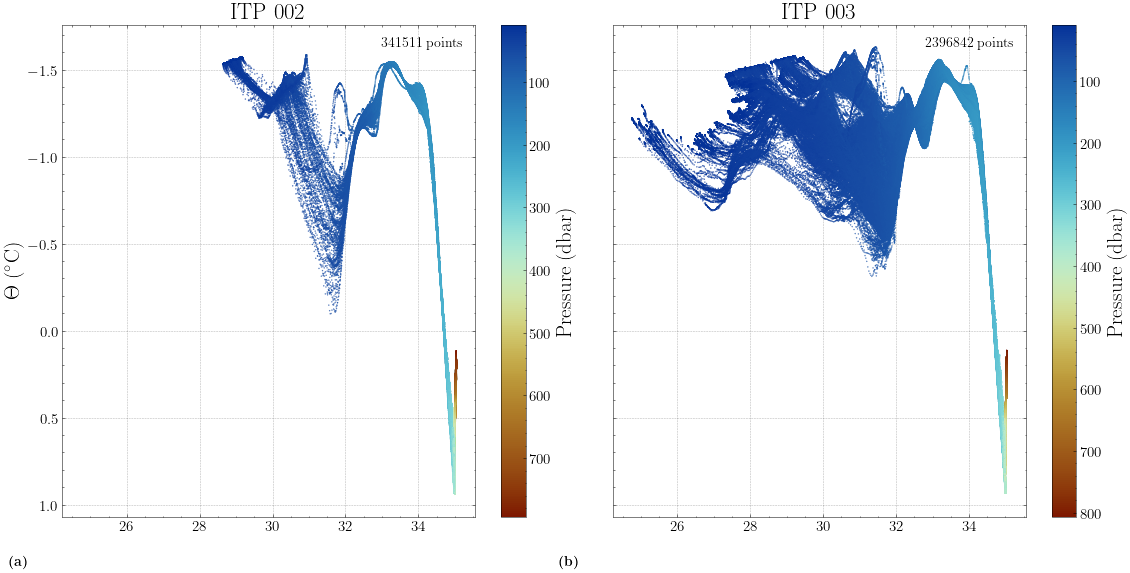

In [13]:
# Make the figure
ahf.make_figure([group_ITP2_test0, group_ITP3_test0])

Notice how the output includes the lines:
```
	- Set share_x_axis to True
	- Set share_y_axis to True
```
This means the code recognized that both subplots had the same variables on the x and y axes, respectively. Therefore, it set the axis bounds to be the same for both such that the larger bounds override smaller ones. The range in $S_A$ for ITP3 has a much lower bound than ITP2. Note, however, that the bounds on the colorbars are not automatically shared.

---
<a id='figure_1'></a>
[back to top](#top)
# Main Figures

## Figure 1

Figure 1 from the study has 4 subplots:
* Subplot a: An example profile from ITP70 showing a staircase
* Subplot b: A map of the entire Arctic, with the BGR boxed in red
* Subplot c: A map of the BGR showing locations of all profiles used, colored by date taken
* Subplot d: A map of the BGR showing a heatmap of the pressure fit of layer 35 

The subplots with maps require the `cartopy` package, the use of which is explained after this next section. First, I will explain how to make just subplot a. Note that both sections assume you have run the above code blocks to import packages and auxiliary scripts and to create the `Profile_Filters` object, `pfs_0`. If you haven't done that, run the following code block first.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline
# For custom analysis functions
import analysis_helper_functions as ahf
# For common BGR parameters
import BGR_params as bps
# For common BGR objects
import BGR_objects as bob
# Create a Profile_Filters object with the default filters
pfs_0 = ahf.Profile_Filters()

### An example profile plot

The code below will create the stand-alone version of Figure 1(a). It specifies several parameters within the `extra_ars` dictionary to change aspects of the plot:
* `plot_pts:False` will just plot a line between all the points in the profile, without also adding markers on top
* `mark_LHW_AW:True` will add the blue (pink) triangles to mark the location of the LHW (AW) core, using the value in `TC_min` (`TC_max`)
* `shift_pfs:False` means, when multiple profiles are present in the plot, it will not shift them horizontally for clarity. If this is set to `True`, the horizontal tick labels will disappear and a scale bar will be added to the plot
* `add_inset:[300,270]` will add an inset showing the vertical scale from `300` at the bottom to `270` at the top (the order the numbers are specified matters). Note that the horizontal scales will automatically be adjusted
* `ax_lims={'y_lims':[770, 0]}` will limit the y-axis to `770` at the bottom and `0` at the top, again with the order these numbers are listed mattering. The limits of the x-axis can be specified in a similar way

- Loading data from netcdfs/ITP_070.nc


- Applying profile filters
- Making the figure
- Subplot 1/1
	- Plotting 1 profiles
	- Profiles to plot: ['2014-03-12 00:02:02']
	- Marking thermocline
	- Plotting TC_max: [0.76343936] press_TC_max: [474.91248]
	- Plotting TC_min: [-1.0761752] press_TC_min: [247.43694]
	- Plotting tw_TC_max: [34.995255] press_TC_max: [474.91248]
	- Plotting tw_TC_min: [34.100803] press_TC_min: [247.43694]
Adding inset to axis in the range 300 to 270
	- Inverting y-axis
	- Set y_lims to [770, 0]
	- Adding grid lines: True


/Users/Grey/Documents/Research/PhD_Projects/Project_2-Staircase_tracking/Tracking_Staircase_Layers/analysis_helper_functions.py:2623: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(pad=0.4, h_pad=tight_layout_h_pad, w_pad=tight_layout_w_pad)


- Displaying figure


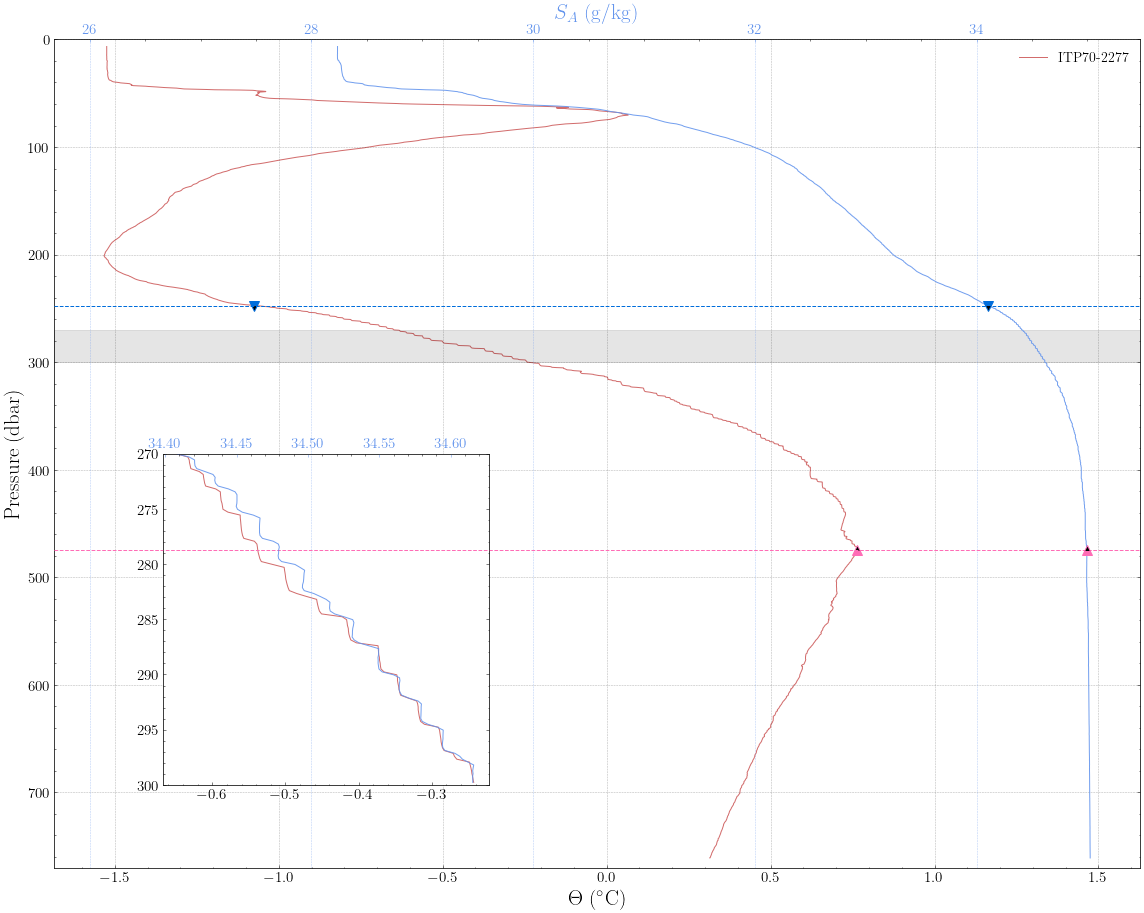

In [2]:
# Make the data set
ds_ITP_ex_pfs = ahf.Data_Set({'ITP_070':['70-2277']}, bob.dfs_all)
# Make the Plot Parameters
pp_pfs1 = ahf.Plot_Parameters(x_vars=['CT','SA'], y_vars=['press'], plot_type='profiles', extra_args={'plot_pts':False, 'mark_LHW_AW':True, 'shift_pfs':False, 'add_inset':[300,270]}, ax_lims={'y_lims':[770, 0]}, legend=True)
# Make the subplot groups
group_example_profiles1 = ahf.Analysis_Group(ds_ITP_ex_pfs, pfs_0, pp_pfs1, plot_title='')
# Make the figure
ahf.make_figure([group_example_profiles1])

### Getting set up with Cartopy

The `map` plot type requires the `cartopy` package to be installed. As noted right before the import command in `analysis_helper_functions.py`, the installation instructions can be found in the [Cartopy docs](https://scitools.org.uk/cartopy/docs/latest/installing.html#installing) and the relevant command is:

```
$ conda install -c conda-forge cartopy
```

However, this just installs the Python package. In order to make the maps, you will also need to download the relevant shape files. The following steps will give you an idea on how to get things set up to actually make maps, but can be difficult and require a bit of debugging. If you don't need good looking maps and just want to plot rough geographical distributions, skip to the `Plotting Longitude vs. Latitude` section.

The relevant shape files are from Natural Earth, the [1:50m Physical Vectors](https://www.naturalearthdata.com/downloads/50m-physical-vectors/) and [1:10m Bathemetry](https://www.naturalearthdata.com/downloads/10m-physical-vectors/10m-bathymetry/). However, the Natural Earth server is prone to issues with downloads, so the files can also be found GitHub user
[nvkelso's natural-earth-vector repository](https://github.com/nvkelso/natural-earth-vector/tree/master/10m_physical/ne_10m_bathymetry_all).

In order to figure out where to put the files, run the following commands:

In [2]:
import cartopy
cartopy.config['data_dir']

'/Users/Grey/.local/share/cartopy'

This will output the location for where Cartopy stores files. From that `cartopy` directory it points to, go down the subdirectory `shapefiles/natural_earth/physical`, or make that subdirectory if it doesn't already exist. Then, put all of the shape files into that `physical` directory flat, meaning not inside any other subdirectories. Note that all the files need to have the prefix `ne_` in order to work.

### Loading the dataset for plotting figures

Below is a block which will load the clustered data for all 17 year-long periods that has been relabeled using salinity divisions to connect layers across all periods. This will be used for many of the figures that are shown below.

In [2]:
this_BGR = 'BGR_all'
# Relabeled based on SA dividers
ds_this_BGR = ahf.Data_Set(bps.BGR_HPC_SA_div_dict[this_BGR], bob.dfs_all)

- Loading data from netcdfs/HPC_BGR0506_clstrd_SA_divs.nc


- Loading data from netcdfs/HPC_BGR0607_clstrd_SA_divs.nc
- Loading data from netcdfs/HPC_BGR0708_clstrd_SA_divs.nc
- Loading data from netcdfs/HPC_BGR0809_clstrd_SA_divs.nc
- Loading data from netcdfs/HPC_BGR0910_clstrd_SA_divs.nc
- Loading data from netcdfs/HPC_BGR1011_clstrd_SA_divs.nc
- Loading data from netcdfs/HPC_BGR1112_clstrd_SA_divs.nc
- Loading data from netcdfs/HPC_BGR1213_clstrd_SA_divs.nc
- Loading data from netcdfs/HPC_BGR1314_clstrd_SA_divs.nc
- Loading data from netcdfs/HPC_BGR1415_clstrd_SA_divs.nc
- Loading data from netcdfs/HPC_BGR1516_clstrd_SA_divs.nc
- Loading data from netcdfs/HPC_BGR1617_clstrd_SA_divs.nc
- Loading data from netcdfs/HPC_BGR1718_clstrd_SA_divs.nc
- Loading data from netcdfs/HPC_BGR1819_clstrd_SA_divs.nc
- Loading data from netcdfs/HPC_BGR1920_clstrd_SA_divs.nc
- Loading data from netcdfs/HPC_BGR2021_clstrd_SA_divs.nc
- Loading data from netcdfs/HPC_BGR2122_clstrd_SA_divs.nc


### Plotting with Cartopy

The following code block makes the `Plot_Parameter` and `Analysis_Group` objects needed to recreate Figure 1 from the study. Here, the `make_figure()` function has been called with a file name that ends in `.pickle` which will save the plot to a pickle object file within the `outputs/` directory. Pickling is a way to save a figure so that you can re-plot it later.

Some points to note about the arguments used for these subplots:
* Subplot b
    * The `extra_args` dictionary for the plot parameters contains: 
        * `'map_extent':'Full_Arctic'` which means it will create a map showing the full Arctic Ocean, with the North Pole in the center
        * `'bbox':'BGR'` which adds the red bounding box around the Beaufort Gyre Area
    * The analysis group uses the full data set `ds_this_BGR`, however restricts the profiles used to a small area defined in the profile filters object `pf_ex_area` defined in the `BGR_objects` script. This is because the plotting functions will fail if no data is passed and so I passed in a very small number of profiles to get an effectively blank map
* Subplot d
    * The `extra_args` dictionary for the plot parameters contains: 
        * `'sort_clstrs':False` which tells the code to not sort the clusters in order of average salinity, which it would do automatically otherwise. This is to make sure that the call to keep cluster 35 selects the correct one
        * `'plot_slopes':True` tells the code to add a fit to the subplot. In this case, because it is a map, it adds a heatmap of the two dimensional polynomial fit as described in the paper. A heatmap will also be used if the x and y variables are `lon` and `lat`
        * `'extra_vars_to_keep':['cluster']` specified extra variables to keep when pulling out the needed data. Generally, the code will only keep the variables needed to make a certain plot in order to reduce overhead. However, with the specified arguments here, it won't automatically identify that will need to keep the `cluster` variable in order to filter to just cluster 35
    * The analysis group uses the profile filters object `pfs_these_clstrs` which specifies that only data points with a `cluster` value of 35 should be added to the plot. Note that the code does this filtering per netcdf, which is why the output `- Only displaying these clusters: [35]` is displayed 17 times, once per netcdf used.

- Loading data from netcdfs/ITP_070.nc


- Applying profile filters
- Applying profile filters
- Applying profile filters
- Applying profile filters
	- Only displaying these clusters: [35]
	- Only displaying these clusters: [35]
	- Only displaying these clusters: [35]
	- Only displaying these clusters: [35]
	- Only displaying these clusters: [35]
	- Only displaying these clusters: [35]
	- Only displaying these clusters: [35]
	- Only displaying these clusters: [35]
	- Only displaying these clusters: [35]
	- Only displaying these clusters: [35]
	- Only displaying these clusters: [35]
	- Only displaying these clusters: [35]
	- Only displaying these clusters: [35]
	- Only displaying these clusters: [35]
	- Only displaying these clusters: [35]
	- Only displaying these clusters: [35]
	- Only displaying these clusters: [35]
- Making the figure
- Subplot a
	- Plotting 1 profiles
	- Profiles to plot: ['2014-03-12 00:02:02']
	- Marking thermocline
	- Plotting TC_max: [0.76343936] press_TC_max: [474.91248]
	- Plotting TC_min: [-1.076175

/Users/Grey/Documents/Research/PhD_Projects/Project_2-Staircase_tracking/Tracking_Staircase_Layers/analysis_helper_functions.py:2623: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(pad=0.4, h_pad=tight_layout_h_pad, w_pad=tight_layout_w_pad)


- Saving figure to outputs/Figure_1.pickle


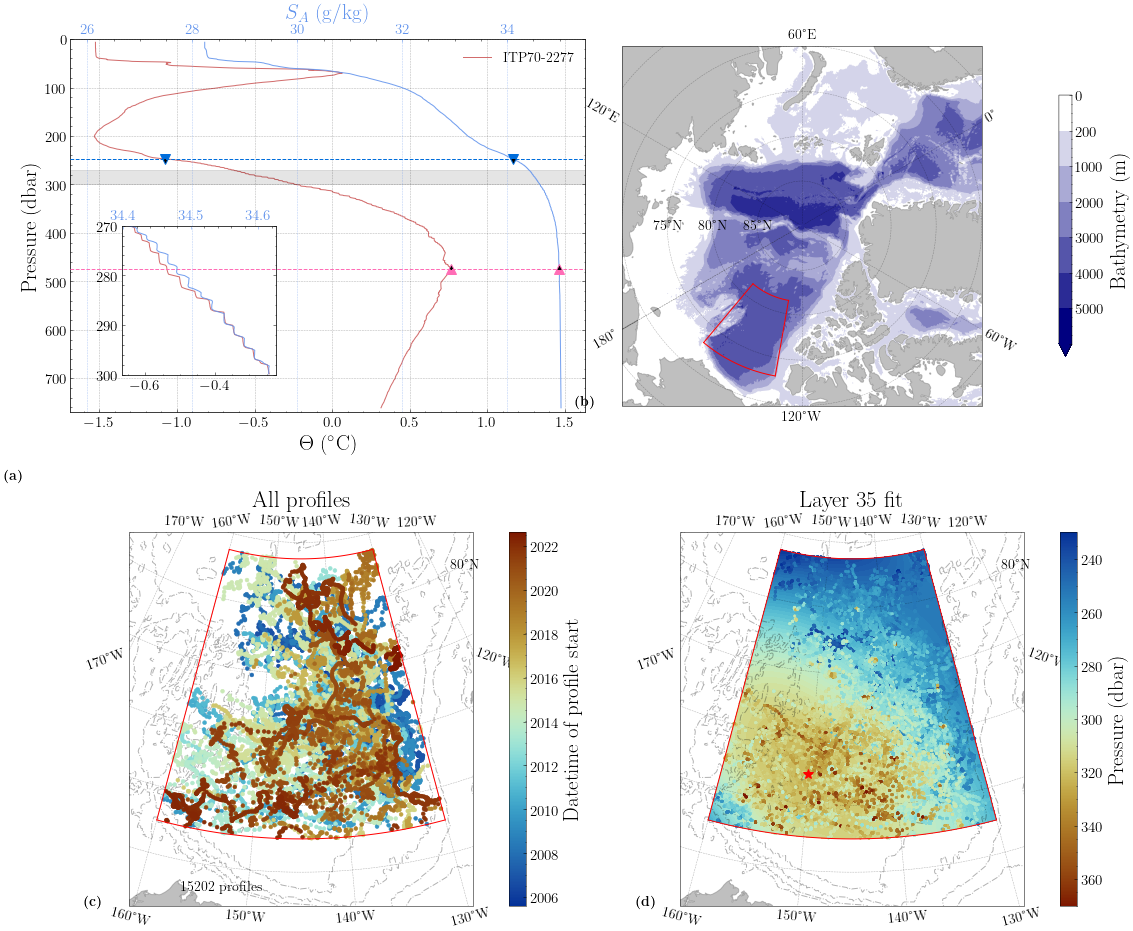

In [4]:
### Figure 1
## Map of all profiles by date, plus map of fit to one cluster
# Specify which cluster to plot for the heatmap
this_cluster_id = 35
# Get the dictionary of ranges for that cluster to adjust the colorbar range
clstr_ranges_dict = bps.BGR_all_clstr_plt_ranges[this_cluster_id]
# Make the profile filters for this cluster
pfs_these_clstrs = ahf.Profile_Filters(clstrs_to_plot=[this_cluster_id])
# Make the Data Sets
ds_ITP_ex_pfs = ahf.Data_Set({'ITP_070':['70-2277']}, bob.dfs_all)
# Make the Plot Parameters
pp_pfs1 = ahf.Plot_Parameters(x_vars=['CT','SA'], y_vars=['press'], plot_type='profiles', extra_args={'plot_pts':False, 'mark_LHW_AW':True, 'shift_pfs':False, 'add_inset':[300,270]}, ax_lims={'y_lims':[770, 0]}, legend=True)
pp_map_full_Arctic = ahf.Plot_Parameters(plot_type='map', clr_map='clr_all_same', extra_args={'map_extent':'Full_Arctic', 'bbox':'BGR'}, legend=False)
pp_map_by_date = ahf.Plot_Parameters(plot_type='map', clr_map='dt_start', extra_args={'map_extent':'Western_Arctic', 'bbox':'BGR'}, legend=True)
pp_map_one_cluster = ahf.Plot_Parameters(plot_type='map', clr_map='press', extra_args={'map_extent':'Western_Arctic', 'bbox':'BGR', 'sort_clstrs':False, 'plot_slopes':True, 'extra_vars_to_keep':['cluster']}, ax_lims={'c_lims':clstr_ranges_dict['press_lims']}, legend=False)
# Make the subplot groups
group_example_profiles1 = ahf.Analysis_Group(ds_ITP_ex_pfs, pfs_0, pp_pfs1, plot_title='')
group_map_full_Arctic = ahf.Analysis_Group(ds_this_BGR, bob.pfs_ex_area, pp_map_full_Arctic, plot_title='')
group_map_by_date = ahf.Analysis_Group(ds_this_BGR, pfs_0, pp_map_by_date, plot_title='All profiles')
group_map_one_cluster = ahf.Analysis_Group(ds_this_BGR, pfs_these_clstrs, pp_map_one_cluster, plot_title='Layer '+str(this_cluster_id)+' fit')
# Make the figure
ahf.make_figure([group_example_profiles1, group_map_full_Arctic, group_map_by_date, group_map_one_cluster], use_same_x_axis=False, use_same_y_axis=False, row_col_list=[2,2, 0.8, 1.4], filename='Figure_1.pickle')

By pickling a figure into a file, this means you can recall it into the matplotlib GUI later without having to go through the pre-calculations necessary to plot. This can save time for figures that take particularly long to generate and allow you to make the subtle adjustments possible within the GUI again or save the image in a different file format without having to re-run the whole code. In order to do this from a command prompt, run a command like:
```
$ python3 unpickle.py outputs/Figure_1.pickle
```

Or, to do so from this notebook, run:

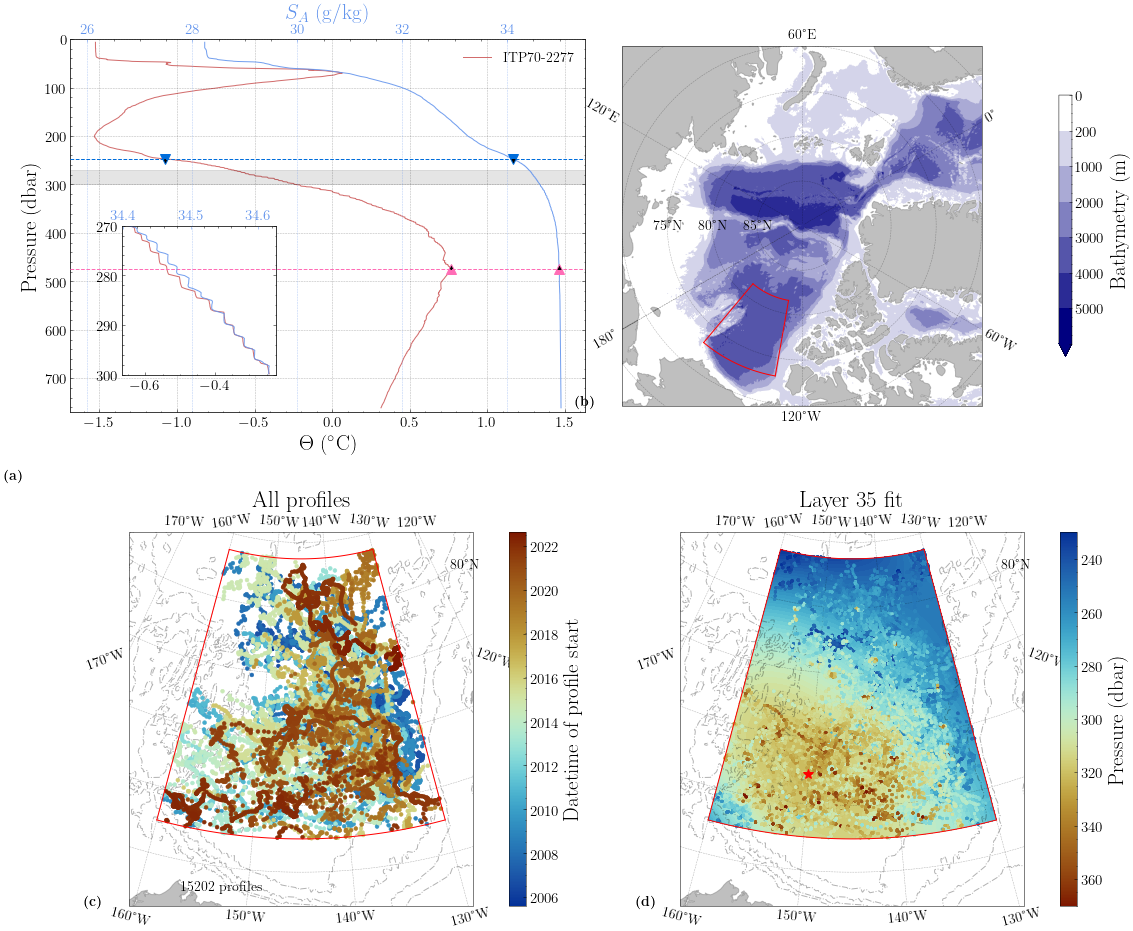

In [6]:
import dill as pl
fig = pl.load(open('outputs/Figure_1.pickle', 'rb'))
plt.show()

### Plotting Longitude vs. Latitude

This section shows how you can plot the geographic distribution of your data without having to use Cartopy. This allows you to avoid that installation and also provides a much quicker way to visualize how data is arranged in geographic space.

Essentially, this involves just making an `xy` plot, but using `lon` and `lat` as the x and y axes. 
The code below recreates Figure 1(c,d) using latitude vs. longitude plots instead of maps.

- Applying profile filters
- Applying profile filters


	- Only displaying these clusters: [35]
	- Only displaying these clusters: [35]
	- Only displaying these clusters: [35]
	- Only displaying these clusters: [35]
	- Only displaying these clusters: [35]
	- Only displaying these clusters: [35]
	- Only displaying these clusters: [35]
	- Only displaying these clusters: [35]
	- Only displaying these clusters: [35]
	- Only displaying these clusters: [35]
	- Only displaying these clusters: [35]
	- Only displaying these clusters: [35]
	- Only displaying these clusters: [35]
	- Only displaying these clusters: [35]
	- Only displaying these clusters: [35]
	- Only displaying these clusters: [35]
	- Only displaying these clusters: [35]
- Making the figure
	- Set share_x_axis to True
	- Set share_y_axis to True
- Subplot a
	- Plot slopes: False
	- Adding subplot label with offsets: -0.13 -0.1
	- Adding grid lines: True
- Subplot b
	- Plot slopes: True
plot_type: None
	- Fitted equation:
	Z = 13.41 + 269.80*X + -1.15*X^2 + 2.22\times10^{-3}*X^3 + 398.8

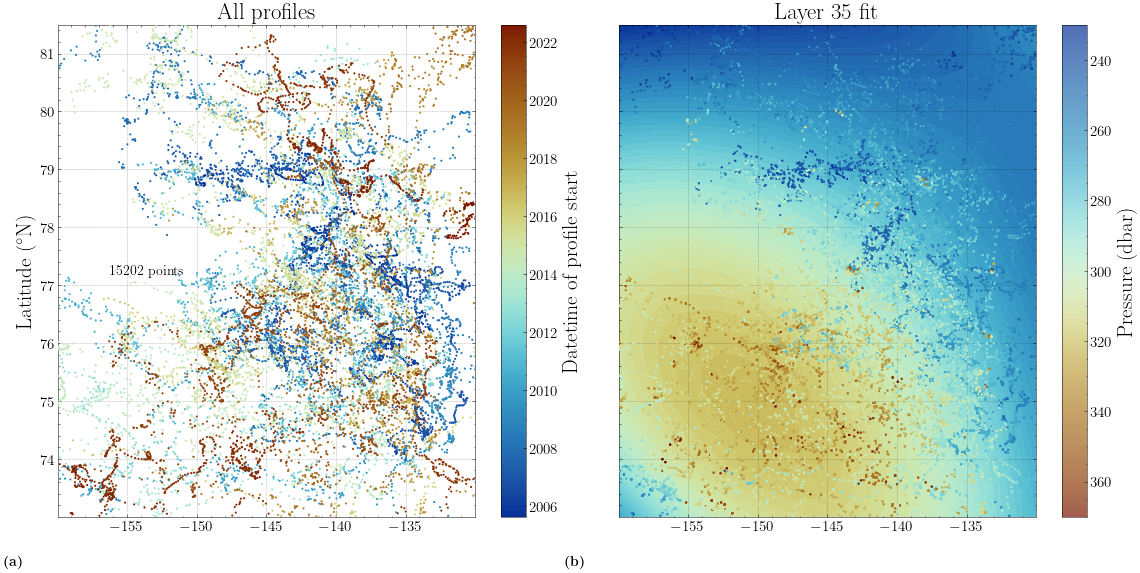

In [5]:
# Specify which cluster to plot for the heatmap
this_cluster_id = 35
# Get the dictionary of ranges for that cluster to adjust the colorbar range
clstr_ranges_dict = bps.BGR_all_clstr_plt_ranges[this_cluster_id]
# Make the profile filters for this cluster
pfs_these_clstrs = ahf.Profile_Filters(clstrs_to_plot=[this_cluster_id])
# Make the Plot Parameters
pp_lat_lon_map_by_date = ahf.Plot_Parameters(x_vars=['lon'], y_vars=['lat'], clr_map='dt_start', legend=True)
pp_lat_lon_map_one_cluster = ahf.Plot_Parameters(x_vars=['lon'], y_vars=['lat'], clr_map='press', extra_args={'sort_clstrs':False, 'plot_slopes':True, 'extra_vars_to_keep':['SA','cluster']}, ax_lims={'c_lims':clstr_ranges_dict['press_lims']}, legend=False)
# Make the Analysis Group
group_lat_lon_map_by_date = ahf.Analysis_Group(ds_this_BGR, pfs_0, pp_lat_lon_map_by_date, plot_title='All profiles')
group_lat_lon_map_one_cluster = ahf.Analysis_Group(ds_this_BGR, pfs_these_clstrs, pp_lat_lon_map_one_cluster, plot_title='Layer '+str(this_cluster_id)+' fit')
# Make the figure
ahf.make_figure([group_lat_lon_map_by_date, group_lat_lon_map_one_cluster])

---
<a id='figure_2'></a>
[back to top](#top)

## Figure 2

Figure 2 from the study has two overall parts which I plot separately. First, I will show how the histogram plots are made, then the plot of clustered salinity over time.

### Salinity histogram plots

In the study, I split the horizontal axis for the histograms into 4 different parts so that the vertical scales can be adjusted for each to show detail. 

The line representing the moving average was calculated when making a figure with one histogram that covers the entire salinity range (see Supplementary Materials figure NOTE MAKE A LINK TO THAT HERE). The values of that moving average are saved to the file `outputs/SA_divs_mv_avg_line.csv`. In order to make sure this moving average line corresponds to the 4 sections of the histogram in the figure below, I need to make sure I use the same bin size. I do this by taking the difference between the minimum and maximum values of the full histogram and dividing it by the number of bins, 1000.

Then, I loop over the specified number of salinity ranges, creating two subplots for each, one of the full histogram (containing all points across all periods) and one for stacked histograms of each year-long period. The `extra_args` dictionaries contain some arguments to specify aspects of the plots:
* `bin_size` is the size of the histogram, necessary to specify specifically to have the moving average line up for the full histograms
* `'pdf_hist':True` means the plot will be in the style of a probability distribution function, however does not normalize the values. It actually creates a line plot, but using the bin centers and bin values as the data points
* `'plot_noise':False` means the code will remove all points marked as noise (with `cluster = -1`) before making the plot

For the stacked histograms, I specify the `clr_map='stacked'` which makes separate histogram lines for each year-long period. Each of these is normalized and shifted vertically for clarity and colored to match the color of the ticks on the vertical axis to specify which line represents which year-long period. When making this type of plot, `pdf_hist` must be set to `True` because other wise there would be no way to shift each line vertically.

- Applying profile filters


- Applying profile filters
- Applying profile filters
- Applying profile filters
- Applying profile filters
- Applying profile filters
- Applying profile filters
- Applying profile filters
- Making the figure
- Subplot a
	- Plot slopes: False
	- Removing noise points
before removing noise points: 827141
after removing noise points: 279136
	- Plotting a histogram
		- Using 248 bins with start: 34.10158, stop: 34.329998, bin_size: 0.0009189643859863282
	- Adding subplot label with offsets: -0.13 -0.18
	- Set x_lims to [34.1, 34.33]
	- Adding grid lines: True
- Subplot b
	- Plot slopes: False
	- Removing noise points
before removing noise points: 1506774
after removing noise points: 680453
	- Plotting a histogram
		- Using 250 bins with start: 34.330006, stop: 34.559998, bin_size: 0.0009189643859863282
	- Adding subplot label with offsets: -0.13 -0.18
	- Set x_lims to [34.33, 34.56]
	- Adding grid lines: True
- Subplot c
	- Plot slopes: False
	- Removing noise points
before removing noise

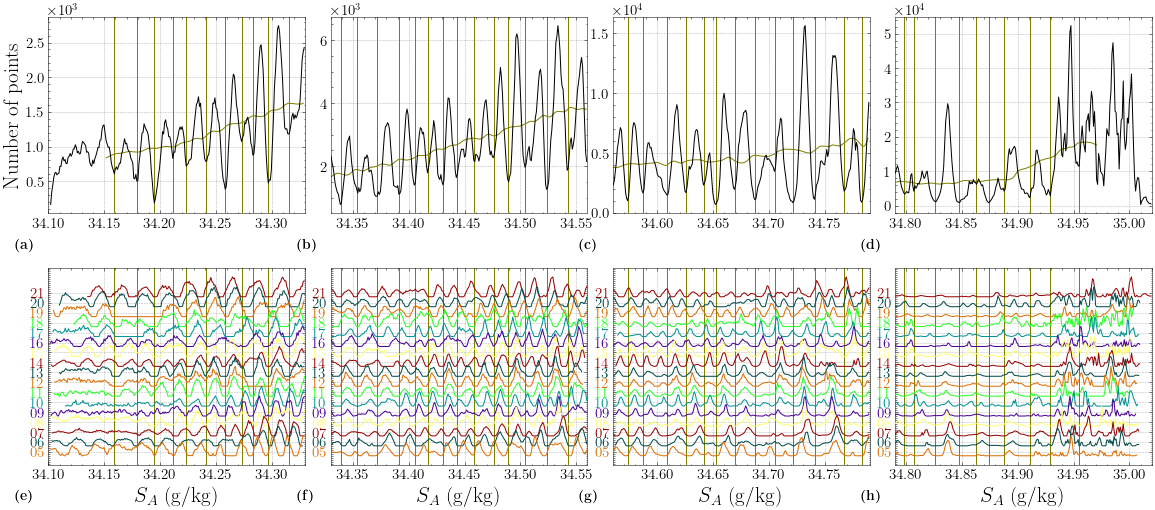

In [3]:
### Figure 2 (a-h)
## A total salinity histogram and salinity "waterfall" histograms of non-noise points for each period, stacked on to each other
# Define the bin size based on the minimum and maximum of the salinity range and the number of bins
S_range_min = np.float32(34.10158)
S_range_max = np.float32(35.020546)
n_h_bins = int(1000)
bin_size = (S_range_max - S_range_min) / n_h_bins
# Decide how many different sub-ranges to split the salinity range into
n_SA_ranges = 4
# Split the S_range_LHW_AW range into n_SA_ranges sub-ranges
SA_ranges = np.linspace(bps.S_range_LHW_AW[0], bps.S_range_LHW_AW[1], n_SA_ranges+1)
groups_to_plot = []
groups_to_plot2 = []
# Make the Plot Parameters, per salinity sub-range
for i in range(n_SA_ranges):
    # Define the salinity range
    this_S_range = [SA_ranges[i], SA_ranges[i+1]]
    # Make the profile filters
    pfs_SA0 = ahf.Profile_Filters(SA_range=this_S_range)
    # Make the Plot Parameters 
    p_SA_hist = ahf.Plot_Parameters(x_vars=['SA'], y_vars=['hist'], clr_map='clr_all_same', extra_args={'bin_size':bin_size, 'pdf_hist':True, 'sort_clstrs':False, 'plt_noise':False, 'extra_vars_to_keep':['cluster']}, ax_lims={'x_lims':this_S_range}, legend=False)
    # Make the subplot group
    groups_to_plot2.append(ahf.Analysis_Group(ds_this_BGR, pfs_SA0, p_SA_hist, plot_title=''))
    # Make the Plot Parameters
    pp_stacked_SA_hist = ahf.Plot_Parameters(x_vars=['SA'], y_vars=['hist'], clr_map='stacked', extra_args={'bin_size':bin_size, 'pdf_hist':True, 'sort_clstrs':False, 'plt_noise':False, 'extra_vars_to_keep':['cluster']}, ax_lims={'x_lims':this_S_range}, legend=False)
    # Make the subplot group
    groups_to_plot.append(ahf.Analysis_Group(ds_this_BGR, pfs_SA0, pp_stacked_SA_hist, plot_title=''))
# Make the figure
ahf.make_figure(groups_to_plot2+groups_to_plot, row_col_list=[2,len(groups_to_plot), 0.45, 1.8], use_same_x_axis=False, use_same_y_axis=False)

### Salinity over time plot

Subplot (i) of Figure 2 shows the values of salinity across time, colored by the layers identified after using the salinity divisions shown in the other subplots of Figure 2. While this plot is fairly straight-forward, a couple of points warrant explanation:
* The values of `dt_this_BGR_x_lims` are calculated to give space on either side of the plot to show the markers of particular layers. This code assumes that the starting and ending months are August, and makes the adjustments from there.
* `use_raster` can be set to `True` or `False` to have the plot be a raster image, even when making a `pdf` version of the file

- Applying profile filters


- Making the figure
- Subplot 1/1
	- Formatting datetime axis (this takes a while)
	- Checking for cluster-based variables
	- ell_sizes: [10]
	- Re-run HDBSCAN: False
	- Using clustering results from file
		Clustering x-axis: ['SA']
		Clustering y-axis: ['la_CT']
		Clustering m_pts:  [450, 1350, 550, 200, 650, 1100, 300, 750, 1300, 500, 1050, 700, 1150]
		Clustering m_cls:  [450, 1350, 550, 200, 650, 1100, 300, 750, 1300, 500, 1050, 700, 1150]
		Moving average window: ['10 dbar ']
		Clustering filters: ['Pressure range: [1000, 5] SA range: [34.1, 35.03] Longitude range: [-160, -130] Latitude range: [73, 81.5] Pressures less than p(TC_max) ']
		Clustering DBCV:   [0.28685099008278825, 0.31715754790211237, 0.16150411367837275, 0.25390080973989554, 0.1796508029607608, 0.11928246534979264, 0.26317314584016555, 0.22564168649207764, 0.29102852684606983, 0.2537369212270983, 0.17193819475657438, 0.21299172439545902, 0.19733257546307675, 0.17720015969709713, 0.18226737630580764, 0.1432894640817

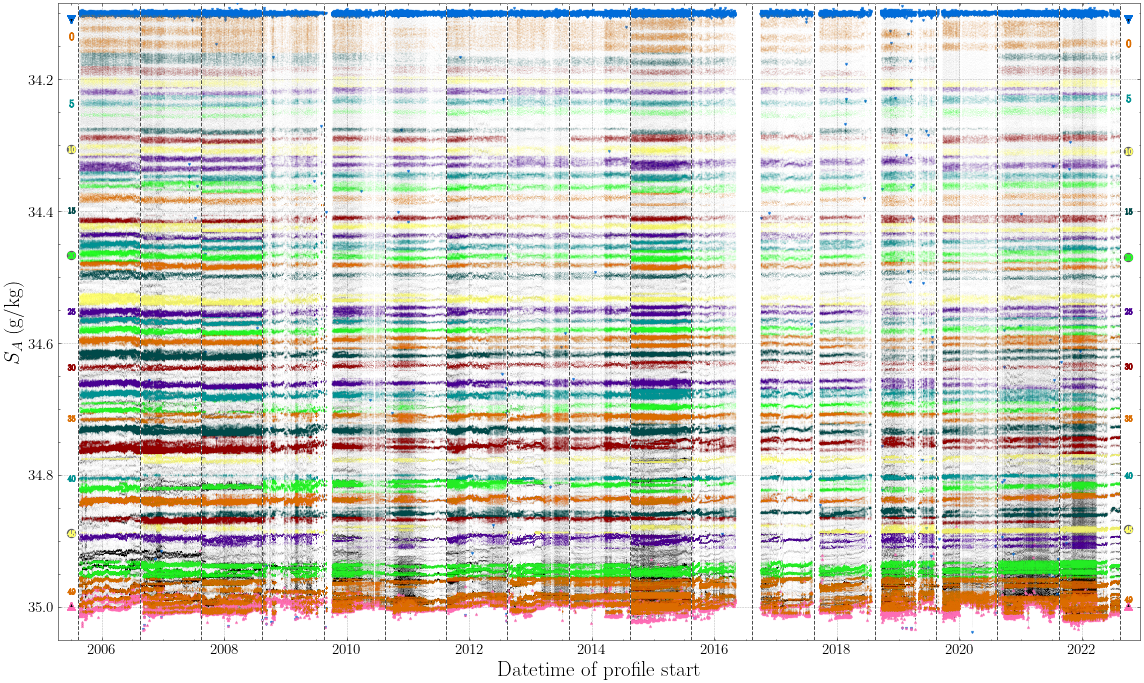

In [6]:
### Figure 2(i)
## Salinity vs. time
# Make x-limits by adding up_or_dn number of months to either side of the date range
dt_this_BGR_x_lims = []
up_or_dn = -4 # integers only
for this_dt in bps.date_range_dict[this_BGR]:
    # Add or subtract up_or_dn to the month in the format 'YYYY/MM/DD HH:MM:SS', padding with zeros
    this_month = str(int(this_dt[5:7])+up_or_dn).zfill(2)
    # If the month is 0, set it to 12 and subtract 1 from the year
    if this_month == '00':
        this_month = '12'
        this_year = str(int(this_dt[0:4])-1).zfill(4)
    # If the month is 13, set it to 1 and add 1 to the year
    elif this_month == '13':
        this_month = '01'
        this_year = str(int(this_dt[0:4])+1).zfill(4)
    # If the 
    else:
        this_year = this_dt[0:4]
    # Add the new date to the list
    dt_this_BGR_x_lims.append(this_year+'/'+this_month+'/'+this_dt[8:])
    up_or_dn = abs(up_or_dn)
# Make the Plot Parameters
pp_SA_vs_dt = ahf.Plot_Parameters(x_vars=['dt_start'], y_vars=['SA'], clr_map='cluster', extra_args={'sort_clstrs':False, 'plt_noise':True, 'mark_LHW_AW':True, 'use_raster':False}, ax_lims={'x_lims':dt_this_BGR_x_lims, 'y_lims':[35.05, 34.085]}, legend=False)
# Make the subplot groups 
group_SA_vs_dt = ahf.Analysis_Group(ds_this_BGR, pfs_0, pp_SA_vs_dt, plot_title='')
# Make the figure
ahf.make_figure([group_SA_vs_dt], row_col_list=[1,1, 0.6, 1.8], filename='Figure_2i.pickle')

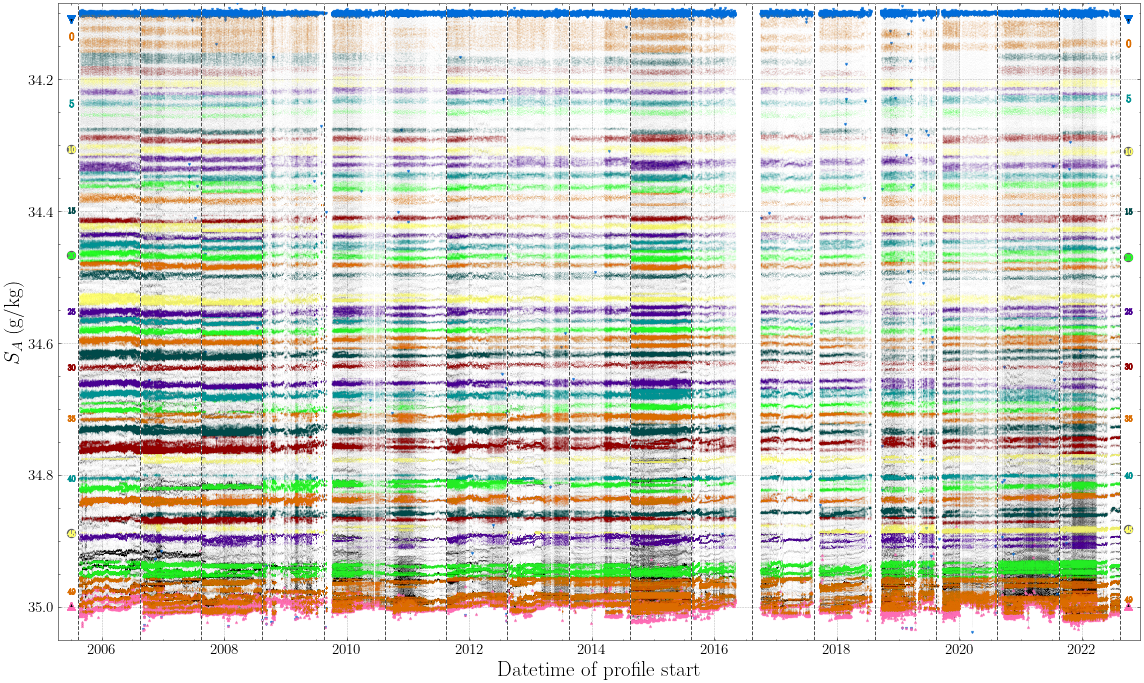

In [4]:
import dill as pl
fig = pl.load(open('outputs/Figure_2i.pickle', 'rb'))
plt.show()

For the study, I combined the two parts of Figure 2 manually.

---
<a id='figure_3'></a>
[back to top](#top)

## Figure 3

Figure 3 from the study shows both the layer average values and layer trends across time (corrected by the fit over longitude and latitude) for conservative temperature, pressure, and layer thickness.

For this plot and others like it, I created modified versions of some functions in `analysis_helper_functions.py` which are stored in `plt_cluster_props.py` where my focus was on using pre-clustered data files to analyze the properties of each cluster. In this case, I am focusing on using pickled data files where I have connected clusters across time periods, so this becomes the same as looking at layer properties. There are two options to load this data for the two methods of connection across time periods: using salinity divisions (shown in the study) or a manual approach (shown in the Supplementary Materials). These pickle files were created by running the `get_clstr_props.py` script which is explained below.

For this figure, I define x-axis limits for the three layer averages plots to emphasize particular domains as zooming out to show outliers would make details difficult to analyze. For the layer trends plots, this was not an issue, however I still needed to define the x-axis limits, even if they are just set to `None`. Since all the plots are basically the same except for the variable across the horizontal and whether to mark the LHW and AW, I define the subplot groups in a loop.

Some points to note about arguments for this figure:
* `plot_slopes = 'OLS'` will have the code calculate a linear trend using Ordinary Least Squares (as long as the x and y variables are not `lon` and `lat`). Setting this to `TLS` will use the implementation of Total Least Squares found in the `orthoregress.py` script
* `'mark_outliers':'ends'` will find and mark layers which are outliers in $R_L$ / `cRL` (in blue) and $IR_{S_A}$ / `nir_SA` (in red) as well as the two endpoint layers on either end of the salinity range (in orange) as they, due to using a moving average to identify the salinity divisions between layers, were not properly distinguished. When this argument is active, all marked layers are excluded from calculations of linear trends
* `'errorbars':True` will add horizontal and vertical error bars to the plots. The error bars are either the layer standard deviation if the variable is the layer average, or the standard error if the variable is the layer trend in time

In [5]:
### Figure 3
## Plots of layer averages and trends for temperature, pressure, and layer thickness
# Import the `plt_cluster_props.py` script
import plt_cluster_props as plt_cp
# Specify which connection method to use
connect_by = 'SA_divs'
# connect_by = 'manual'
filename = this_BGR+'_'+connect_by
# Unpickle the data frames from file
import dill as pl
df = pl.load(open('outputs/'+filename+'_layer_properties.pickle', 'rb'))
bnds_df = pl.load(open('outputs/'+this_BGR+'_LHW_AW_properties.pickle', 'rb'))
# Define x-axis limits for the layer averages plots
x_lims_dict = {
                'ca_press':[200,450],       # cluster average pressure
                'ca_CT':[-1.2,0.9],         # cluster average conservative temperature
                'nzca_pcs_press':[-0.2,7],  # non-zero cluster average profile cluster span in pressure (thickness)
                'trd_CT-fit':None,          # trend in conservative temperature
                'trd_press-fit':None,       # trend in pressure
                'percnztrd_pcs_press':None  # percentage change trend of non-zero cluster average profile cluster span in pressure (thickness)
}
# Define what method to use for calculating linear fit slopes
plot_slopes = 'OLS'     # Orginary Least Squares
# Choose the variable to plot on the vertical axes
# this_ca_var = 'ca_press'
this_ca_var = 'ca_SA'
# Choose whether to include a legend on the plots
add_legend = False
# Define the color map to use for the plots
#   The study plots every layer as the same color, but if 'cluster' is used, 
#   each layer will be marked in the color it has in Figure 2i
for this_clr_map in ['clr_all_same']:#, 'cluster']:
    # Make an empty list to hold the subplot groups
    groups_to_plot = []
    if this_ca_var == 'ca_press':
        these_y_lims = [355,190]
    elif this_ca_var == 'ca_SA':
        these_y_lims = [bps.S_range_LHW_AW[1], bps.S_range_LHW_AW[0]]
    for this_plt_var in ['ca_CT', 'ca_press', 'nzca_pcs_press', 'trd_CT-fit', 'trd_press-fit', 'percnztrd_pcs_press']:
        # Make the Plot Parameters
        if this_plt_var in ['nzca_pcs_press', 'percnztrd_pcs_press']:
            mrk_LHW_AW = False
        else:
            mrk_LHW_AW = True
        if this_plt_var == 'ca_press':
            lgnd = False
        else:
            lgnd = add_legend
        pp_ca_plot = ahf.Plot_Parameters(x_vars=[this_plt_var], y_vars=[this_ca_var], clr_map=this_clr_map, extra_args={'sort_clstrs':False, 'plot_noise':False, 'plot_slopes':plot_slopes, 'mark_outliers':'ends', 'extra_vars_to_keep':['cluster', 'press', 'cRL','nir_SA'], 'mark_LHW_AW':mrk_LHW_AW, 'errorbars':True}, legend=lgnd, ax_lims={'x_lims':x_lims_dict[this_plt_var], 'y_lims':these_y_lims})
        # Make the subplot groups
        groups_to_plot.append(ahf.Analysis_Group2([df], pp_ca_plot, plot_title=''))
    # Make the figure
    plt_cp.make_figure(groups_to_plot)

	- Set share_x_axis to False
	- Set share_y_axis to True
	- Using same x axis: False
	- Using same y axis: True
- Subplot a
	- x_err_key: csd_CT
	- y_err_key: csd_SA
	- Adding errorbars: True
	- Marking outliers: ends
	- Marking outliers in cRL and nir_SA
Found outliers:
[ 0.73646021  0.28583947  0.12092113  0.05498883 -0.03689954 -0.13754988
 -1.1098063 ]
[34.98233795 34.81549072 34.756073   34.73159027 34.6973381  34.66103363
 34.13269043]
	- Non-outlier data in x:
[0.6317182779312134, 0.4913119673728943, 0.3457726538181305, 0.2153039574623108, -0.00903097353875637, -0.0935700461268425, -0.18430586159229279, -0.21844111382961273, -0.2597961127758026, -0.3142698407173157, -0.3599661588668823, -0.39807507395744324, -0.43477097153663635, -0.4804811477661133, -0.5233025550842285, -0.563676655292511, -0.628850519657135, -0.6682447195053101, -0.6964831948280334, -0.7237710356712341, -0.7408871054649353, -0.7873793840408325, -0.8129611015319824, -0.8296139240264893, -0.8506894707679749, -0.

/Users/Grey/miniconda3/envs/clusterer/lib/python3.7/site-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


Found outliers:
[57.07732837  4.0036848   4.09897096  2.96537111  1.98111787  1.90789654
  1.68360219]
[34.98233795 34.81549072 34.756073   34.73159027 34.6973381  34.66103363
 34.13269043]
	- Non-outlier data in x:
[20.538305459660624, 6.11833349186473, 4.560883979299783, 2.460261988043219, 2.028008831541307, 2.179227859994453, 1.1410542454332704, 1.6597875790022323, 1.9221745639734422, 2.025673104524967, 1.2951160953102852, 1.25552091400131, 1.5807420907503413, 1.5835763133064906, 1.589415509513255, 1.1141150527972288, 1.17794186572678, 1.0104074608307843, 0.7423819439504321, 0.7041292841416027, 0.6455742450776042, 0.7433108359286471, 0.9823679618037856, 0.7230257248956525, 0.6357762186036765, 1.008826957100827, 0.6724351606930233, 0.47437932623059276, 0.4845898326142999, 0.5056292716037022, 0.4934995764484425, 0.3824355941497252, 0.41454770993828194, 0.5303058867629445, 2.389947745762469, 0.8926038874770497, 0.4248873141567403, 0.38235479598270383, 4.991056476547954, 2.7497439753249

- Displaying figure


Note that, for the study, I manually added in the legend which labels the markers for the LHW, AW, $R_L$ outliers, and endpoint. The code can display this legend if that argument in the plot parameters is set to `True`, however this will replace the text that gives the value and units of the linear slopes as I did not implement the functionality to have both at the same time. To be able to have that legend on just one subplot, you can adjust the code under `if this_plt_var == 'ca_press':` to be `lgnd = True`.

#### Layer thicknesses take along time to calculate

The layer thicknesses and their trends shown in Figure 3 (c,f) take a long time to calculate. They have been pre-calculated and are stored in pickle files in this repository. Below, I will explain how they are calculated and why they take so long.

The `get_clstr_props.py` script created the pickle files used to make the above plot. That script takes a very long time to run when the `calc_pcs_vars` variable is set to `True`. If it is set to `False`, then the `get_clstr_props.py` script will create a file named in the format `'outputs/'+filename+'_layer_properties.pickle'` which contains all the layer properties that are on a full-layer basis. For example, it will contain values of layer average temperature, pressure, and salinity which are the averages over all points within a layer across all profiles across all time periods.

When the `calc_pcs_vars` variable is set to `True`, the script will calculate and output a pickle file named in the format `'outputs/'+filename+'_pf_layer_properties.pickle'` which contains layer properties that are per profile. As the code stands, the only property that is calculated on a per-profile basis is `pcs_press` which is the profile cluster span of pressure, also known as thickness. This variable has one value per profile, per layer. The values are the differences between the maximum and minimum values of pressure for a layer within a particular profile. If there is only one point within a certain layer for a particular profile, the corresponding value of `pcs_press` will be `0`. When all of these calculations are done, it outputs the `'outputs/'+filename+'_pf_layer_properties.pickle'` as well as inserting these values into the `'outputs/'+filename+'_layer_properties.pickle'` file.

I implemented the calculations of `pcs_press` (and other similar variables) using a nested for-loop. It loops across each profile, of which there are 15,202. For each profile, it loops across each layer, of which there are 50. It identifies which points within the current profile are within the current layer. From these points, it finds the maximum and minimum values of pressure, then takes the difference between the two. This is the span in pressure (or thickness) and this value is stored before moving on to the next layer. This is an embarrassingly parallelizable problem as each of these calculations is completely separate. However, I never got around to making a parallel version of this code. I only needed to run it twice (once for the salinity divisions version of the connection method and once for the manual approach) and each time took about 5-6 days of continuous computation on my laptop.

If, for some reason, you do need to recalculate `pcs_press`, I would highly suggest investing the time to parallelize it. Otherwise, just use the values of `pcs_press` for the two connection methods that I included in the pickle files in this repository.

---
<a id='figure_s1'></a>
[back to top](#top)
# Supplementary Figures

## Figure S.1

Figure 4 from the study shows the lateral density ratio $R_L$ and the normalized inter-cluster range in practical salinity $IR_{S_P}$ for all the clusters found in ITP2.

### Cluster variable prefixes

The plots in Figure 4 make use of the "cluster average" prefix `ca_` which can be prepended to any regular variable, examples of which are:
* Vertical measure
    * `press`, pressure in dbar
    * `depth`, depth in meters below the surface
* Temperature
    * `iT`, insitu temperature $T$ in $^\circ$C
    * `PT`, potential temperature $\theta$ in $^\circ$C
    * `CT`, conservative temperature $\Theta$ in $^\circ$C
* Salinity
    * `SP`, practical salinity $S_P$ in g/kg
    * `SA`, absolute salinity $S_A$ in g/kg

The cluster average prefix `ca_` is one of the following prefixes which can be added to a variable:
* `pca_`, Profile cluster average
    * For each profile, the average value of the points within each cluster
    * Reduces number of points to just one per cluster per profile
* `pcs_`, Profile cluster span
    * For each profile, finds the span (maximum - minimum) of the points within each cluster
    * Reduces number of points to just one per cluster per profile
* `cmc_`, Cluster mean centered
    * For each cluster, finds the mean value, then subtracts that value from each point in that cluster
    * Should not change the number of points to display
* `ca_`, Cluster average
    * For each cluster, finds the mean value
    * Reduces number of points to just one per cluster
* `cs_`, Cluster span
    * For each cluster, finds the span (maximum - minimum) of the points
    * Reduces number of points to just one per cluster
* `cmm_`, Cluster minimum / maximum
    * For each cluster, finds the minimum and maximum value
    * Note: for a given variable `var`, this won't actually fill values in `cmm_var`, but instead fill values in both `cmin_var` and `cmax_var`
    * Reduces number of points to just two per cluster
* `nir_`, normalized inter-cluster range $IR_v$
    * For each cluster, finds the normalized inter-cluster range
    * Reduces number of points to just one per cluster
* `cRL`, cluster's lateral density ratio $R_L$
    * For each cluster, uses orthogonal distance regression to calculate $R_L$
    * Note: not actually a prefix. Do not try to apply this to a variable
    * Reduces number of points to just one per cluster

For Figure 4, we use the `ca_` prefix on the pressure, `ca_press`, to plot one point per cluster, either against the cluster's lateral density ratio `cRL` or the normalized inter-cluster range for practical salinity `nir_SP`. We use the `extra_args` dictionary to apply `plot_slopes` to the plot of `cRL` which will find a line of best fit to the data but, as mentioned above, this is the only case where it will apply a 2nd degree polynomial instead of a linear function.

- Loading data from netcdfs/HPC_BGR0506_clstrd_SA_divs.nc
- Loading data from netcdfs/HPC_BGR0607_clstrd_SA_divs.nc
- Loading data from netcdfs/HPC_BGR0708_clstrd_SA_divs.nc
- Loading data from netcdfs/HPC_BGR0809_clstrd_SA_divs.nc
- Loading data from netcdfs/HPC_BGR0910_clstrd_SA_divs.nc
- Loading data from netcdfs/HPC_BGR1011_clstrd_SA_divs.nc
- Loading data from netcdfs/HPC_BGR1112_clstrd_SA_divs.nc
- Loading data from netcdfs/HPC_BGR1213_clstrd_SA_divs.nc
- Loading data from netcdfs/HPC_BGR1314_clstrd_SA_divs.nc
- Loading data from netcdfs/HPC_BGR1415_clstrd_SA_divs.nc
- Loading data from netcdfs/HPC_BGR1516_clstrd_SA_divs.nc
- Loading data from netcdfs/HPC_BGR1617_clstrd_SA_divs.nc
- Loading data from netcdfs/HPC_BGR1718_clstrd_SA_divs.nc
- Loading data from netcdfs/HPC_BGR1819_clstrd_SA_divs.nc
- Loading data from netcdfs/HPC_BGR1920_clstrd_SA_divs.nc
- Loading data from netcdfs/HPC_BGR2021_clstrd_SA_divs.nc
- Loading data from netcdfs/HPC_BGR2122_clstrd_SA_divs.nc
- Applying pro

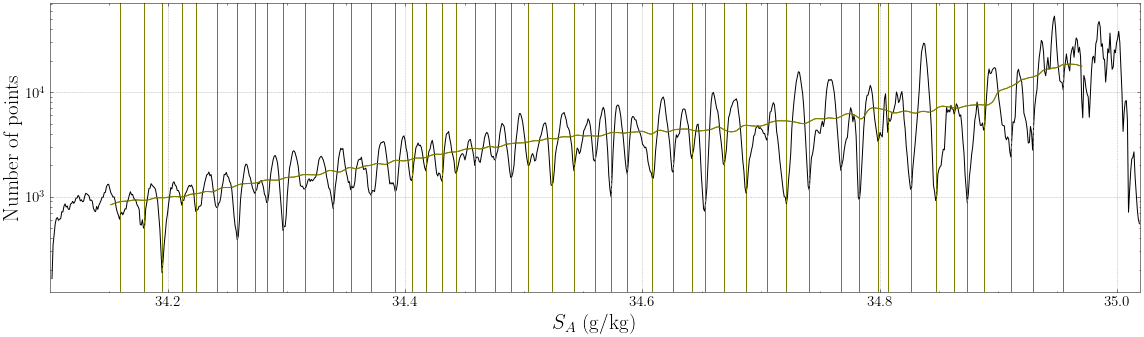

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline
# For custom analysis functions
import analysis_helper_functions as ahf
# For common BGR parameters
import BGR_params as bps
# For common BGR objects
import BGR_objects as bob
# Create a Profile_Filters object with the default filters
pfs_0 = ahf.Profile_Filters()
# Relabeled based on SA dividers
ds_this_BGR = ahf.Data_Set(bps.BGR_HPC_SA_div_dict['BGR_all'], bob.dfs_all)

#**# Salinity histogram of non-noise points for all periods (Supplementary Materials)
# Make the Plot Parameters 
pp_SA_vs_dt = ahf.Plot_Parameters(x_vars=['SA'], y_vars=['hist'], clr_map='clr_all_same', extra_args={'n_h_bins':1000, 'pdf_hist':True, 'mv_avg':0.1, 'sort_clstrs':False, 'plt_noise':False, 'log_axes':[False,True,False], 'extra_vars_to_keep':['cluster']}, ax_lims={'x_lims':bps.S_range_LHW_AW}, legend=False)
# pp_SA_vs_dt2 = ahf.Plot_Parameters(x_vars=['dt_start'], y_vars=['SA'], extra_args={'n_h_bins':n_bins, 'pdf_hist':False, 'sort_clstrs':False, 'plt_noise':True, 'log_axes':[False,False,False], 'extra_vars_to_keep':['cluster']}, ax_lims={'y_lims':[35.05, 34.085]}, legend=False)
# Make the subplot groups 
group_SA_vs_dt = ahf.Analysis_Group(ds_this_BGR, pfs_0, pp_SA_vs_dt, plot_title='')
# group_SA_vs_dt2 = ahf.Analysis_Group(ds_this_BGR, pfs_0, pp_SA_vs_dt2, plot_title='')
# Make the figure
# ahf.make_figure([group_SA_vs_dt, group_SA_vs_dt2])
ahf.make_figure([group_SA_vs_dt], row_col_list=[1,1, 0.3, 1.8])

- Applying profile filters
- Applying profile filters
	- Set share_y_axis to True
- Subplot a
	- Re-run HDBSCAN: False
	- Using clustering results from file
		Clustering x-axis: ['SP']
		Clustering y-axis: ['la_CT']
		Clustering m_pts:  [170]
		Clustering filters:   ['SP_range: [34.05, 34.75]']
		Clustering DBCV:   [0.30342676754223524]
		Calculating extra clustering variables
	- Marking outliers
found outliers:
[-12.73531397 -13.89352954  16.96352552]
[231.62178251 201.96688308 188.42902762]
	- Sum of square residuals: 53.552513907682375
	- Total sum of squares: 160.3532701170966
	- R^2: 0.6660341640143908
	- Inverting y-axis
	- Adding grid lines: True
- Subplot b
	- Re-run HDBSCAN: False
	- Using clustering results from file
		Clustering x-axis: ['SP']
		Clustering y-axis: ['la_CT']
		Clustering m_pts:  [170]
		Clustering filters:   ['SP_range: [34.05, 34.75]']
		Clustering DBCV:   [0.30342676754223524]
		Calculating extra clustering variables
cluster,std_SP
	- Marking outliers
found

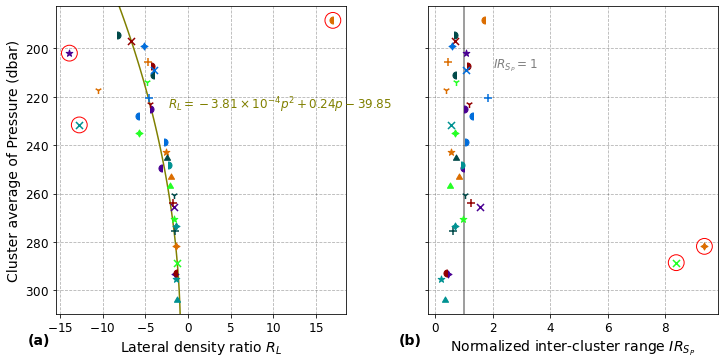

In [10]:
### Figure 4
## Evaluating clusterings with the lateral density ratio and the normalized inter-cluster range
# Make the Profile Parameters
pp_salt_R_L = ahf.Plot_Parameters(x_vars=['cRL'], y_vars=['ca_press'], clr_map='cluster', extra_args={'plot_slopes':True}, legend=False)
pp_salt_nir = ahf.Plot_Parameters(x_vars=['nir_SP'], y_vars=['ca_press'], clr_map='cluster', legend=False)
# Make the Analysis Groups
group_salt_R_L = ahf.Analysis_Group(ds_ITP2_all, pfs_ITP2, pp_salt_R_L, plot_title='')
group_salt_nir = ahf.Analysis_Group(ds_ITP2_all, pfs_ITP2, pp_salt_nir, plot_title='')
# Make the Figure
ahf.make_figure([group_salt_R_L, group_salt_nir])

### Finding outliers

Figure 4 shows several of the points circled in red. These are outliers in the horizontal variable, defined to be when the point's z-score is greater than 2. For this version of the code, the outliers will be found automatically in the following circumstances:
* If plotting with `clr_map` as `cluster`
    * Will be applied if the x variable contains `nir`, `cRL`, or `ca`
* If plotting with `clr_map` as `clr_all_same`
    * Will be applied if `plot_slopes` is `True`

I acknowledge that there may be many more scenarios where finding outliers might be helpful, but I haven't added any more functionality for this into the code.

---
<a id='figure_5'></a>
[back to top](#top)

## Figure 5

Figure 5 from the study shows two sets of example profiles from ITP2, chosen to illustrate the some of the outliers shown in Figure 4.

### Plot types

The `Plot_Parameter` objects accept an optional argument called `plot_type`. Figure 1 used this argument as `map` to add the coastlines and bathymetry. If you don't specify, `plot_type` defaults to `xy`, which is what was used for Figures 2-4. Here, we will specify the `profiles` plot type, which tells the code to plot individual profiles. However, it is important to specify which profiles to plot because the plot will be unreadable if you include the hundreds of profiles collected by an ITP.

When plotting multiple profiles, the code will automatically shift them in the x-axis so they don't overlap. Since shifting them means that the absolute value of the x-axis is meaningless, the ticks are removed and a scale bar is added.

### Profiles to plot

You can specify a set of profiles to include in your plot by adding the `pfs_to_plot` argument to the `extra_args` dictionary. The value should be a list of profile numbers. Note that, by default, the code only includes upgoing profiles. So, if the profiles you specify in this list are downgoing, they will be skipped.

Using the `pfs_to_plot` argument is very similar to using a `Data_Set` object with specific profiles specified (i.e. `ds_ITP2_pfs`). If you aren't re-running HDBSCAN, these two methods are equivalent. However, if you are re-running HDBSCAN, the algorithm will run over the data included by the `Data_Set` object and so if you would like to run the algorithm over all the data from an ITP but only display a few profiles, you will need to include all profiles in the `Data_Set` object then add the `pfs_to_plot` argument with just the profiles you wish to display.

In [8]:
### Figure 5
## Tracking clusters across a subset of profiles
# For showing multiple layers grouped into one cluster
ITP2_some_pfs_0 = [87, 89, 95, 97, 99, 101, 103, 105, 109, 111]
ITP2_some_pfs_ax_lims_0 = {'y_lims':[245,220]}
# For showing one layer split into multiple clusters
ITP2_some_pfs_1 = [67, 69, 73, 75, 81, 83, 91, 93, 97, 99]
ITP2_some_pfs_ax_lims_1 = {'y_lims':[295,270]}
# Make the Profile Parameters
pp_ITP2_some_pfs_0  = ahf.Plot_Parameters(x_vars=['SP'], y_vars=['press'], plot_type='profiles', clr_map='cluster', extra_args={'pfs_to_plot':ITP2_some_pfs_0, 'plt_noise':True}, legend=False, ax_lims=ITP2_some_pfs_ax_lims_0)
pp_ITP2_some_pfs_1  = ahf.Plot_Parameters(x_vars=['SP'], y_vars=['press'], plot_type='profiles', clr_map='cluster', extra_args={'pfs_to_plot':ITP2_some_pfs_1, 'plt_noise':True}, legend=False, ax_lims=ITP2_some_pfs_ax_lims_1)
# Make the Analysis Groups
group_ITP2_some_pfs_0 = ahf.Analysis_Group(ds_ITP2_all, pfs_ITP2, pp_ITP2_some_pfs_0, plot_title='')
group_ITP2_some_pfs_1 = ahf.Analysis_Group(ds_ITP2_all, pfs_ITP2, pp_ITP2_some_pfs_1, plot_title='')

- Applying profile filters
- Applying profile filters


### Sharing x and y axes

The code will automatically detect when you have multiple plots that have the same variable on the same axis and set them to share axis bounds. For example, in Figure 2, panels (a) and (c) have the same x-axis and the code automatcially set it so they share the same bounds. However, when making Figure 5, we don't want them to share the same bounds as we are looking at different depth ranges, so we set both `use_same_x_axis` and `use_same_y_axis` to `False` when making the figure.

### Subpanel arrangements

When making a plot with multiple subpanels, the code will automatically arrange them and size the image to be generally applicable to most plots. However, if you want to have a specific arrangement, you can add the `row_col_list` argument when making the figure. It is a list of the following in order:
* Number of rows
* Number of columns
* Aspect ratio
* Figure size

Because we want Figure 5 to have two plots, one on top of the other, we specify 2 rows and 1 column.

- Subplot a
	- Re-run HDBSCAN: False
	- Using clustering results from file
		Clustering x-axis: ['SP']
		Clustering y-axis: ['la_CT']
		Clustering m_pts:  [170]
		Clustering filters:   ['SP_range: [34.05, 34.75]']
		Clustering DBCV:   [0.30342676754223524]
	- Profiles to plot: [ 87.  89.  95.  97.  99. 101. 103. 105. 109. 111.]
	- Inverting y-axis-
	- Set y_lims to [245, 220]
	- Adding grid lines: True
- Subplot b
	- Re-run HDBSCAN: False
	- Using clustering results from file
		Clustering x-axis: ['SP']
		Clustering y-axis: ['la_CT']
		Clustering m_pts:  [170]
		Clustering filters:   ['SP_range: [34.05, 34.75]']
		Clustering DBCV:   [0.30342676754223524]
	- Profiles to plot: [67. 69. 73. 75. 81. 83. 91. 93. 97. 99.]
	- Inverting y-axis-
	- Set y_lims to [295, 270]
	- Adding grid lines: True
- Displaying figure


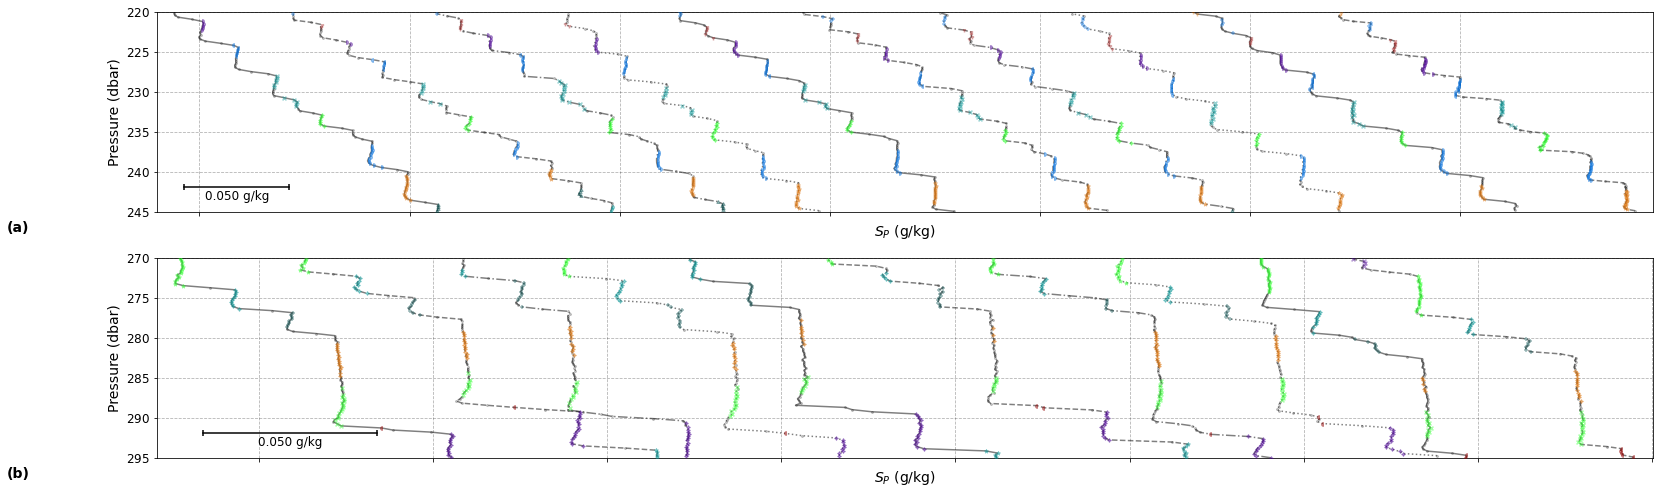

In [9]:
# Make the Figure
ahf.make_figure([group_ITP2_some_pfs_0, group_ITP2_some_pfs_1], use_same_x_axis=False, use_same_y_axis=False, row_col_list=[2,1, 0.3, 1.70])

---
<a id='figure_6'></a>
[back to top](#top)

## Figure 6

Figure 6 from the study shows, for ITP3, the average pressure, $\Theta$, and $S_P$ for each cluster within each profile across time.

This plot uses starting datetime `dt_start` on the x-axis and the profile cluster average `pca_` of pressure, conservative temperature, and practical salinity.

Note: this plot takes significantly longer to create compared to Figures 2-5 due to the fact that ITP3 has many more profiles and finding the profile cluster average is computationally demanding.

- Applying profile filters
- Applying profile filters
- Applying profile filters
	- Set share_x_axis to True
	- Turning off excess x axes
- Subplot a
	- Re-run HDBSCAN: False
	- Using clustering results from file
		Clustering x-axis: ['SP']
		Clustering y-axis: ['la_CT']
		Clustering m_pts:  [580]
		Clustering filters:   ['SP_range: [34.21, 34.82]']
		Clustering DBCV:   [0.3861603831174808]
		Calculating extra clustering variables
	- Inverting y-axis-
	- Adding grid lines: True
- Subplot b
	- Re-run HDBSCAN: False
	- Using clustering results from file
		Clustering x-axis: ['SP']
		Clustering y-axis: ['la_CT']
		Clustering m_pts:  [580]
		Clustering filters:   ['SP_range: [34.21, 34.82]']
		Clustering DBCV:   [0.3861603831174808]
		Calculating extra clustering variables
	- Inverting y-axis-
	- Adding grid lines: True
- Subplot c
	- Re-run HDBSCAN: False
	- Using clustering results from file
		Clustering x-axis: ['SP']
		Clustering y-axis: ['la_CT']
		Clustering m_pts:  [580]
		Clusterin

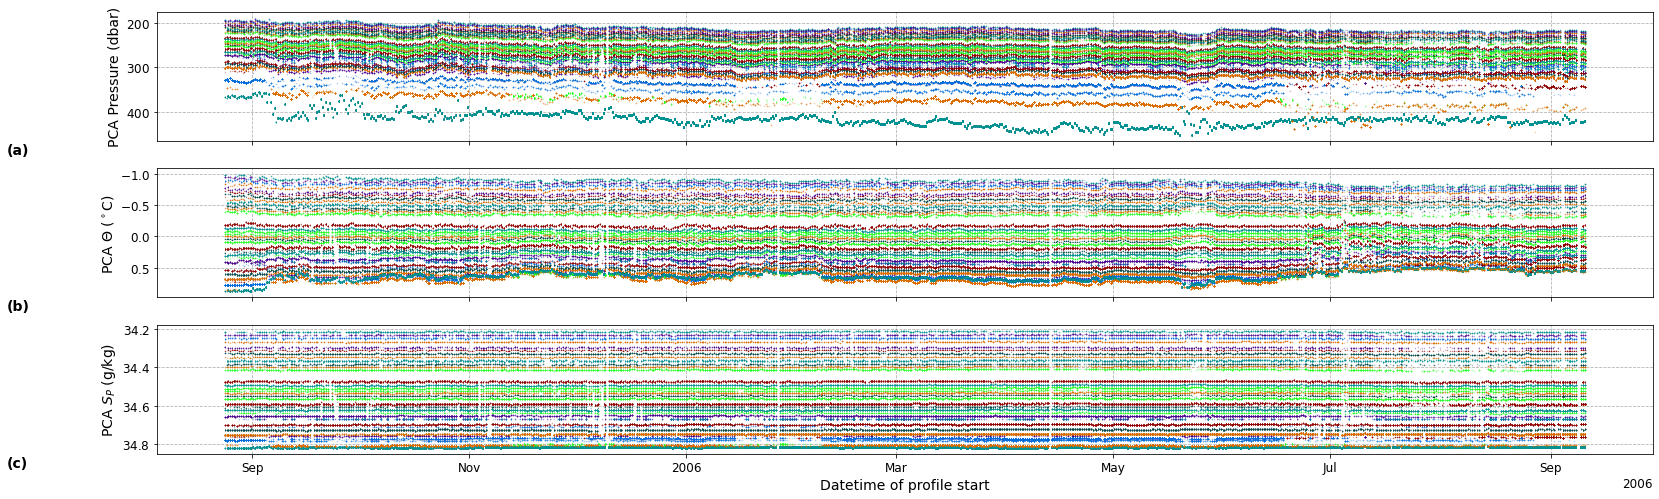

In [10]:
### Figure 6
## Tracking clusters across profiles, reproducing Lu et al. 2022 Figure 3
# Make the Profile Parameters
pp_Lu2022_fig3a = ahf.Plot_Parameters(x_vars=['dt_start'], y_vars=['pca_press'], clr_map='cluster', legend=False)
pp_Lu2022_fig3b = ahf.Plot_Parameters(x_vars=['dt_start'], y_vars=['pca_CT'], clr_map='cluster', legend=False)
pp_Lu2022_fig3c = ahf.Plot_Parameters(x_vars=['dt_start'], y_vars=['pca_SP'], clr_map='cluster', legend=False)
# Make the subplot groups
group_Lu2022_fig3a = ahf.Analysis_Group(ds_ITP3_all, pfs_ITP3, pp_Lu2022_fig3a, plot_title='')
group_Lu2022_fig3b = ahf.Analysis_Group(ds_ITP3_all, pfs_ITP3, pp_Lu2022_fig3b, plot_title='')
group_Lu2022_fig3c = ahf.Analysis_Group(ds_ITP3_all, pfs_ITP3, pp_Lu2022_fig3c, plot_title='')
# Make the figure
if False:
    # Takes a long time to run
    ahf.make_figure([group_Lu2022_fig3a, group_Lu2022_fig3b, group_Lu2022_fig3c])
else:
    import dill as pl
    fig = pl.load(open('outputs/Figure_6.pickle', 'rb'))
    plt.show()

---
<a id='figure_7'></a>
[back to top](#top)

## Figure 7

Figure 7 from the study shows the average $\Theta$ and $S_P$ for each cluster found in ITP3 data and the layers found by Lu et al. 2022.

This plot requires using data from an outside source, `Lu2022_Table_A1.csv`, which is a spreadsheet of exactly the values reported by Lu et al. 2022 in their table A1. Because of this, there is a separate script `compare_to_Lu2022.py` which creates Figure 7. We can run this file by importing it like a library:

In [11]:
import compare_to_Lu2022

- Loading outputs/Lu2022_Table_A1.csv
- Loading outputs/ITP3_cluster_table.csv
- Displaying figure


---
<a id='figure_8'></a>
[back to top](#top)

## Figure 8

Figure 8 from the study shows an example set of profiles from ITP3, chosen to illustrate remnant intrusions. Here, in contrast to Figure 5, we use a `Data_Set` object to select the profiles to plot. This reduces the amount of data significantly which helps the code run faster as ITP3 has many profiles compared to ITP2. This also shows how you can have multiple x-axes for profile plots. A second scale bar is added automatically.


- Applying profile filters
	- Re-run HDBSCAN: False
	- Using clustering results from file
		Clustering x-axis: ['SP']
		Clustering y-axis: ['la_CT']
		Clustering m_pts:  [580]
		Clustering filters:   ['SP_range: [34.21, 34.82]']
		Clustering DBCV:   [0.3861603831174808]
	- Profiles to plot: [313. 315. 317. 319. 321.]
	- Inverting y-axis
	- Set y_lims to [370, 300]
	- Adding grid lines: True
- Displaying figure


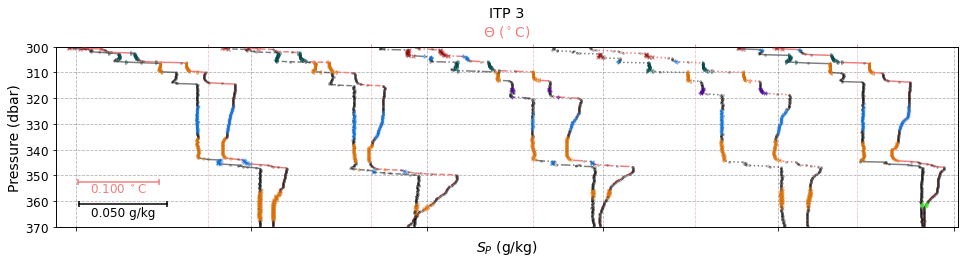

In [13]:
### Figure 8
## Tracking clusters across a subset of profiles
ITP3_some_pfs_2 = [313, 315, 317, 319, 321]
ITP3_pfs2  = {'ITP_3':ITP3_some_pfs_2}
ds_ITP3_some_pfs2 = ahf.Data_Set(ITP3_pfs2, dfs0)
ITP3_some_pfs_ax_lims_2 = {'y_lims':[370,300]}
# Make the Profile Parameters
pp_ITP3_some_pfs_2 = ahf.Plot_Parameters(x_vars=['SP','CT'], y_vars=['press'], plot_type='profiles', clr_map='cluster', extra_args={'plt_noise':True}, legend=False, ax_lims=ITP3_some_pfs_ax_lims_2)
# Make the Analysis Group
group_ITP3_some_pfs_2 = ahf.Analysis_Group(ds_ITP3_some_pfs2, pfs_ITP3, pp_ITP3_some_pfs_2)
# Make the figure
ahf.make_figure([group_ITP3_some_pfs_2], row_col_list=[1,1, 0.27, 0.90])

---
<a id='other_figures'></a>
[back to top](#top)

# Other Figures

Above, we have shown how to creat all the figures used in the study. However, there are other types of figures which this code can create which may be helpful in exploring a dataset.

---
<a id='histo_grams'></a>
[back to top](#top)

## Histograms

You can create histograms by specifying the `hist` variable for either the x or y axis. Note, you cannot have multiple variables on the axis using `hist`. By default, the number of bins is 25 per standard deviation. You can change this value by specifying `n_h_bins` in the `extra_args` dictionary.

In [7]:
## Histogram of practical salinity
# Make the Plot Parameters
pp_SP_hist = ahf.Plot_Parameters(x_vars=['SP'], y_vars=['hist'], clr_map='clr_all_same')
# Make the Analysis Group
group_SP_hist = ahf.Analysis_Group(ds_ITP2_all, pfs_ITP2, pp_SP_hist)
# Make the figure
ahf.make_figure([group_SP_hist])

- Applying profile filters
	- Adding grid lines: True
- Displaying figure


### Histograms by cluster

You can specify the `clr_map` to be `cluster` for that same histogram. This creates a histogram for each cluster that are all overlapping and colored accordingly. The cluster's associated symbol is plotted at the average variable value and what should be the maximum number of points value, but because of binning is usually a bit higher than that. When making histograms for clusters, a twin axis for the number of noise points is added by default. This can be turned off by setting `plt_noise` to `False` in the `extra_args`.

- Applying profile filters
	- Re-run HDBSCAN: False
	- Using clustering results from file
		Clustering x-axis: ['SP']
		Clustering y-axis: ['la_CT']
		Clustering m_pts:  [170]
		Clustering filters:   ['SP_range: [34.05, 34.75]']
		Clustering DBCV:   [0.30342676754223524]
	- Adding grid lines: True
- Displaying figure


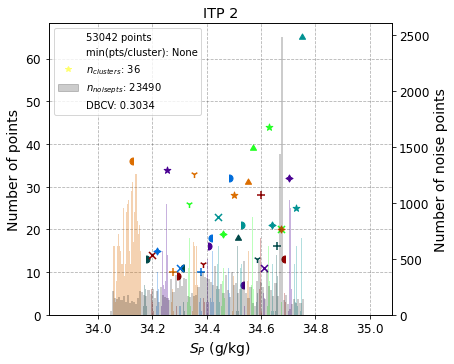

In [8]:
## Histogram of practical salinity by cluster
# Make the Plot Parameters
pp_SP_clstr_hist = ahf.Plot_Parameters(x_vars=['SP'], y_vars=['hist'], clr_map='cluster')
# Make the Analysis Group
group_SP_clstr_hist = ahf.Analysis_Group(ds_ITP2_all, pfs_ITP2, pp_SP_clstr_hist)
# Make the figure
ahf.make_figure([group_SP_clstr_hist])

### 2D Histograms

You can also make 2D histograms which show the density of points in each grid cell of a plot. You can specify parameters of how it will display:
* `clr_min`, the minimum point for the color bar. Must be 0 or greater
* `clr_max`, the maximum point for the color bar
* `clr_ext`, how to deal with values that go beyond the colorbar
    * `max` will set all values above `clr_max` to the same color and create an arrow on that end of the colorbar
* `xy_bins`, the number of bins to have in the x and y directions
    * The code doesn't currently have any way to have different numbers of bins in x and y

- Applying profile filters
	- Adding grid lines: True
- Displaying figure


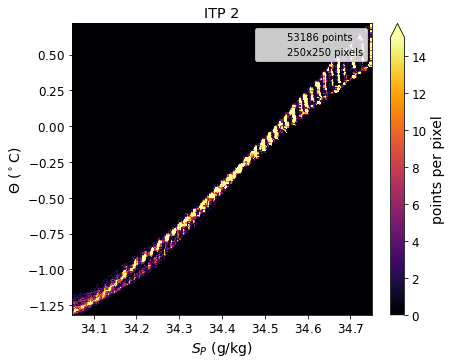

In [10]:
## Density histogram of conservative temperature vs practical salinity
# Make the Plot Parameters
pp_CT_SP_2d_hist = ahf.Plot_Parameters(x_vars=['SP'], y_vars=['CT'], clr_map='density_hist', legend=True, extra_args={'clr_min':0, 'clr_max':15, 'clr_ext':'max', 'xy_bins':250})
# Make the Analysis Group
group_CT_SP_2d_hist = ahf.Analysis_Group(ds_ITP2_all, pfs_ITP2, pp_CT_SP_2d_hist)
# Make the figure
ahf.make_figure([group_CT_SP_2d_hist])

---
<a id='HDBSCAN_params'></a>
[back to top](#top)

## Adjusting HDBSCAN parameters

There are 4 parameters which will affect what clusters the HDBSCAN algorithm finds:
* The profiles included
* The range of data used
* The value of $\ell$ selected for the moving average window
* The value of $m_{pts}$ selected

### Profiles to be included

In a `Data_Filters` object, you can filter what profiles will be included by any combination of the direction (up or down), the geographic region, or the dates they were taken.

#### Profile direction

By default, the code will only take upgoing profiles to avoid the distortions made by the wake of the instrument when it is moving downwards. The following code shows how you can add the `cast_direction` argument to a `Data_Filters` object to select one of the following three options:
* `up`
    * Just the upgoing profiles. This is selected by default if no value of `cast_direction` is given
* `down`
    * Just the downgoing profiles
* `all`
    * All the profiles regardless of direction

- Applying profile filters
- Applying profile filters
- Applying profile filters
	- Set share_x_axis to True
	- Set share_y_axis to True
- Subplot a
	- Adding grid lines: True
- Subplot b
	- Adding grid lines: True
- Subplot c
	- Adding grid lines: True
- Displaying figure


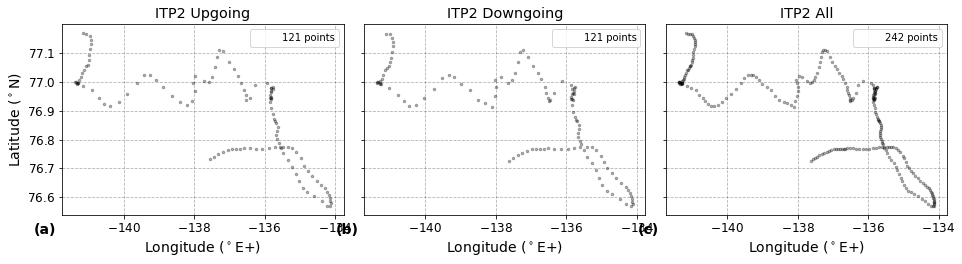

In [7]:
## Up, Down, and All profiles
# Data Filters
dfs_up  = ahf.Data_Filters(cast_direction='up')
dfs_dwn = ahf.Data_Filters(cast_direction='down')
dfs_all = ahf.Data_Filters(cast_direction='all')
# Data Sets
ds_up__ITP2 = ahf.Data_Set(ITP2_all, dfs_up)
ds_dwn_ITP2 = ahf.Data_Set(ITP2_all, dfs_dwn)
ds_all_ITP2 = ahf.Data_Set(ITP2_all, dfs_all)
# Make the Plot Parameters
pp_lon_lat = ahf.Plot_Parameters(x_vars=['lon'], y_vars=['lat'], clr_map='clr_all_same')
# Make the Analysis Groups
group_up__ITP2 = ahf.Analysis_Group(ds_up__ITP2, pfs_0, pp_lon_lat, plot_title='ITP2 Upgoing')
group_dwn_ITP2 = ahf.Analysis_Group(ds_dwn_ITP2, pfs_0, pp_lon_lat, plot_title='ITP2 Downgoing')
group_all_ITP2 = ahf.Analysis_Group(ds_all_ITP2, pfs_0, pp_lon_lat, plot_title='ITP2 All')
# Make the figure
ahf.make_figure([group_up__ITP2, group_dwn_ITP2, group_all_ITP2], row_col_list=[1,3, 0.27, 0.90])

#### Geographic region

By default, the code will not filter profiles based on geographic extent. But, you can add the `geo_extent` to a `Data_Filters` object to select a particular region. At the moment, the only region that the code recognizes is the Canada Basin, `CB`. The following code filters to just profiles within the `CB`, but since all of ITP2's profiles are within that region, you can't actually see the difference.

- Applying profile filters
- Applying profile filters
	- Set share_x_axis to True
	- Set share_y_axis to True
- Subplot a
	- Adding grid lines: True
- Subplot b
	- Adding grid lines: True
- Displaying figure


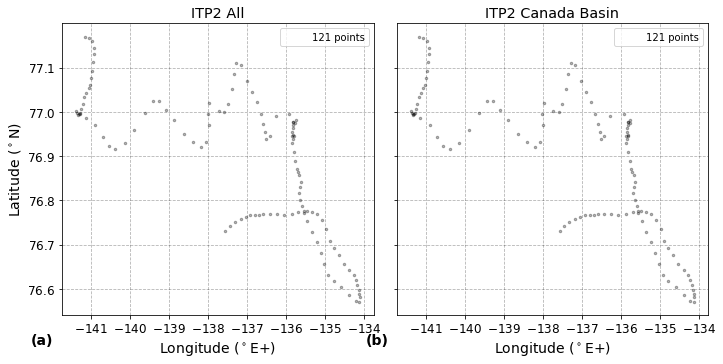

In [8]:
## Filtering to the Canada Basin
# Data Filters
dfs_0  = ahf.Data_Filters()
dfs_CB = ahf.Data_Filters(geo_extent='CB')
# Data Sets
ds_any_ITP2 = ahf.Data_Set(ITP2_all, dfs_0)
ds_CB_ITP2  = ahf.Data_Set(ITP2_all, dfs_CB)
# Make the Plot Parameters
pp_lon_lat = ahf.Plot_Parameters(x_vars=['lon'], y_vars=['lat'], clr_map='clr_all_same')
# Make the Analysis Groups
group_any_ITP2 = ahf.Analysis_Group(ds_any_ITP2, pfs_0, pp_lon_lat, plot_title='ITP2 All')
group_CB_ITP2  = ahf.Analysis_Group(ds_CB_ITP2, pfs_0, pp_lon_lat, plot_title='ITP2 Canada Basin')
# Make the figure
ahf.make_figure([group_any_ITP2, group_CB_ITP2])

#### Date Range

If you would like to look at only a certain time period, you can add the `date_range` argument to a `Data_Filters` object. It accepts a list in the format `['start_date','end_date']` where the dates are strings in the format `'YYYY/MM/DD'` or `None` to keep all profiles.

- Applying profile filters
- Applying profile filters
	- Set share_x_axis to True
	- Set share_y_axis to True
- Subplot a
	- Adding grid lines: True
- Subplot b
	- Adding grid lines: True
- Displaying figure


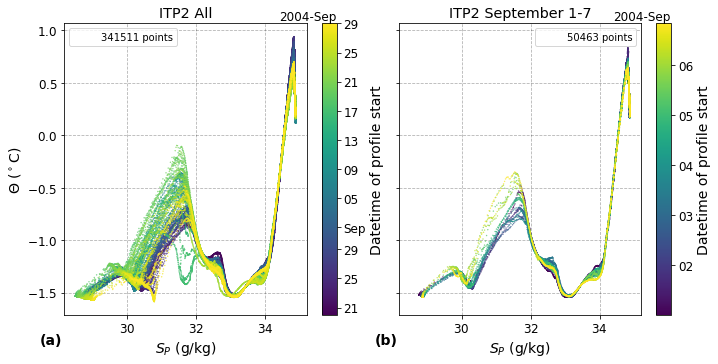

In [12]:
## Filtering to a specific date range
# Data Filters
dfs_0   = ahf.Data_Filters(date_range=None)
dfs_Sep = ahf.Data_Filters(date_range=['2004/09/01 00:00:00','2004/09/07 00:00:00'])
# Data Sets
ds_any_ITP2 = ahf.Data_Set(ITP2_all, dfs_0)
ds_Sep_ITP2 = ahf.Data_Set(ITP2_all, dfs_Sep)
# Make the Plot Parameters
pp_SP_CT = ahf.Plot_Parameters(x_vars=['SP'], y_vars=['CT'], clr_map='dt_start')
# Make the Analysis Groups
group_any_ITP2 = ahf.Analysis_Group(ds_any_ITP2, pfs_0, pp_SP_CT, plot_title='ITP2 All')
group_Sep_ITP2 = ahf.Analysis_Group(ds_Sep_ITP2, pfs_0, pp_SP_CT, plot_title='ITP2 September 1-7')
# Make the figure
ahf.make_figure([group_any_ITP2, group_Sep_ITP2])

### Data Ranges

As was shown with practical salinity `SP` above, you can add various arguments to the `Profile_Filters` object to filter to a particular range for a certain variable. They all accept lists in the format `[starting_value, ending_value]`. The variables available for filtering are:
* `p_range`
    * Pressure range
    * Note, the starting value should be the value farthest to the surface which is the larger number
* `d_range`
    * Depth range
    * Note, the starting value should be the value farthest to the surface which is the larger number
* `iT_range`
    * insitu temperature range
* `CT_range`
    * Conservative temperature range
* `PT_range`
    * Potential temperature range
* `SP_range`
    * Practical salinity range
* `SA_range`
    * Absolute salinity range

The following code shows examples of these with filters on pressure and conservative temperature.

In [14]:
## Filtering to pressure and temperature ranges
# Profile Filters
pfs_press = ahf.Profile_Filters(p_range=[300,185])
pfs_temp  = ahf.Profile_Filters(CT_range=[-1,0])
# Make the Plot Parameters
pp_press = ahf.Plot_Parameters(x_vars=['SP'], y_vars=['CT'], clr_map='press')
# Make the Analysis Groups
group_p_filt_ITP2 = ahf.Analysis_Group(ds_ITP2_all, pfs_press, pp_press, plot_title='ITP2 Pressure filter')
group_t_filt_ITP2 = ahf.Analysis_Group(ds_ITP2_all, pfs_temp, pp_press, plot_title='ITP2 Temperature filter')
# Make the figure
ahf.make_figure([group_p_filt_ITP2, group_t_filt_ITP2])

- Applying profile filters
- Applying profile filters
	- Set share_x_axis to True
	- Set share_y_axis to True
- Subplot a
	- Adding grid lines: True
- Subplot b
	- Adding grid lines: True
- Displaying figure


### Value of $\ell$ for the moving average window

The value of $\ell$ sets the moving average window size used when calculating the local anomaly of temperature, $\Theta'$. By default, this is set by the value used in the `take_moving_average.py` script. But, you can use the `m_avg_win` argument in a `Profile_Filters` object to change this. The result is stored in variables with the moving average prefix `ma_` which is then in turn used to calculate the local anomaly `la_` variables. The code below makes a couple example plots showing the difference between the original profiles and the profiles after being smoothed with different sized moving average windows.

- Applying profile filters
	In take_m_avg(), m_avg_win: 10
- Applying profile filters
	In take_m_avg(), m_avg_win: 50
- Applying profile filters
	In take_m_avg(), m_avg_win: 100
- Applying profile filters
	In take_m_avg(), m_avg_win: 150
	- Set share_y_axis to True
- Subplot a
	- Profiles to plot: [185.]
	- Adding grid lines: True
- Subplot b
	- Profiles to plot: [185.]
	- Adding grid lines: True
- Subplot c
	- Profiles to plot: [185.]
	- Adding grid lines: True
- Subplot d
	- Profiles to plot: [185.]
	- Adding grid lines: True
- Displaying figure


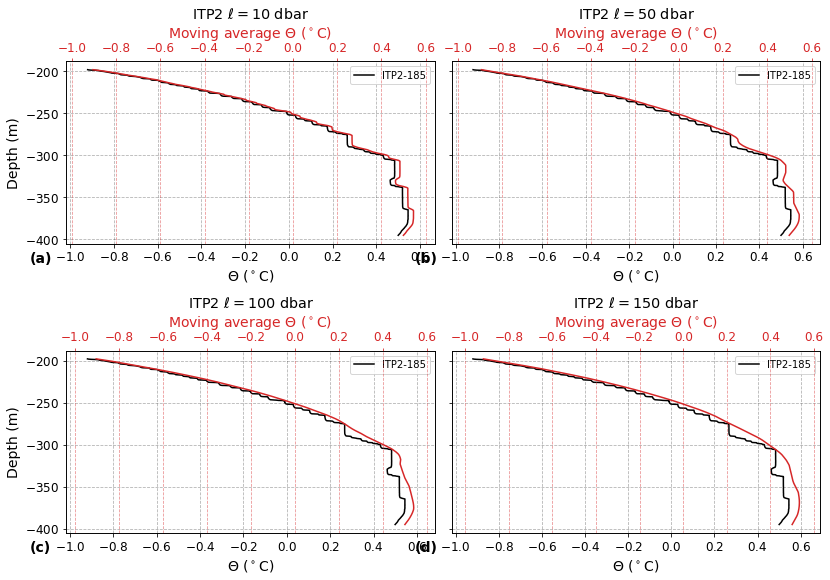

In [15]:
## Changing the value of \ell
# Data Set
ds_ITP2_185 = ahf.Data_Set({'ITP_2':[185]}, dfs0)
# Profile filters
test_p_range = [400,200]
pfs_ell_10  = ahf.Profile_Filters(p_range=test_p_range, m_avg_win=10)
pfs_ell_50  = ahf.Profile_Filters(p_range=test_p_range, m_avg_win=50)
pfs_ell_100 = ahf.Profile_Filters(p_range=test_p_range, m_avg_win=100)
pfs_ell_150 = ahf.Profile_Filters(p_range=test_p_range, m_avg_win=150)
# Make the Plot Parameters
pp_CT_ma_CT = ahf.Plot_Parameters(x_vars=['CT','ma_CT'], y_vars=['depth'], plot_type='profiles')
# Make the Analysis Groups
group_ell_010 = ahf.Analysis_Group(ds_ITP2_185, pfs_ell_10, pp_CT_ma_CT, plot_title=r'ITP2 $\ell=10$ dbar')
group_ell_050 = ahf.Analysis_Group(ds_ITP2_185, pfs_ell_50, pp_CT_ma_CT, plot_title=r'ITP2 $\ell=50$ dbar')
group_ell_100 = ahf.Analysis_Group(ds_ITP2_185, pfs_ell_100,pp_CT_ma_CT, plot_title=r'ITP2 $\ell=100$ dbar')
group_ell_150 = ahf.Analysis_Group(ds_ITP2_185, pfs_ell_150,pp_CT_ma_CT, plot_title=r'ITP2 $\ell=150$ dbar')
# Make the figure
ahf.make_figure([group_ell_010, group_ell_050, group_ell_100, group_ell_150])

### Value of $m_{pts}$ for HDBSCAN

Figure 3 showed a parameter sweep across values of $\ell$ and $m_{pts}$. Here, we show an example of re-running HDBSCAN for just one example set of parameters and viewing the resulting clusters.

- Applying profile filters
-- `cluster` not in df columns, re_run: True
	- Re-run HDBSCAN: True
	- Running HDBSCAN
		Clustering x-axis: SP
		Clustering y-axis: la_CT
		Clustering m_pts:  100
	- Adding grid lines: True


/Users/Grey/Documents/Research/PhD_Projects/Project_1-Staircase_detection/Staircase_Clustering_Detection_Algorithm/analysis_helper_functions.py:1559: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(pad=0.4, h_pad=tight_layout_h_pad, w_pad=tight_layout_w_pad)


- Displaying figure


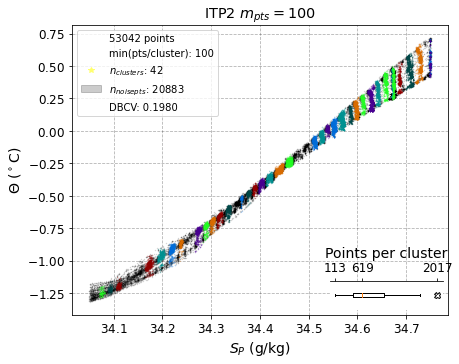

In [16]:
## Changing the value of m_pts
# Make the Plot Parameters
pp_m_pts_100 = ahf.Plot_Parameters(x_vars=['SP'], y_vars=['CT'], clr_map='cluster', legend=True, extra_args={'b_a_w_plt':True, 'cl_x_var':'SP', 'cl_y_var':'la_CT', 'm_pts':100})
# Make the Analysis Groups
group_m_pts_100 = ahf.Analysis_Group(ds_ITP2_all, pfs_ITP2, pp_m_pts_100, plot_title=r'ITP2 $m_{pts}=100$')
# Make the figure
ahf.make_figure([group_m_pts_100])

---
<a id='re_gridding'></a>
[back to top](#top)

## Re-gridding temperature and slainity data

You can add the `regrid_TS` argument to a `Profile_Filters` object to regrid the data, essentially reducing the resolution in temperature and salinity. The `regrid_TS` argument expects a list of 4 things:
* String of the 1st variable
    * For example, `CT` for conservative temperature $\Theta$
* A numerical value for the regrid of the 1st variable
    * All values of the 1st variable will be shifted to the closest value on a grid with this sized spacing
* String of the 2nd variable
    * For example, `SP` for practical salinity $S_P$
* A numerical value for the regrid of the 2nd variable
    * All values of the 2nd variable will be shifted to the closest value on a grid with this sized spacing

Below is an example comparing the original data from ITP2 in a narrowed $S_P$ range to the same data regridded to $0.01^\circ$ C and $0.005$ g/kg.

In [9]:
## Regrid
# Make the Profile Filters
pfs_0 = ahf.Profile_Filters(SP_range=ITP2_SP_range)
pfs_regrid = ahf.Profile_Filters(SP_range=ITP2_SP_range, regrid_TS=['CT',0.01,'SP',0.005])
# Make the Plot Parameters
pp_0 = ahf.Plot_Parameters(x_vars=['SP'], y_vars=['CT'], clr_map='clr_all_same', legend=True)
# Make the Analysis Group
group_0 = ahf.Analysis_Group(ds_ITP2_all, pfs_0, pp_0)
group_regrid = ahf.Analysis_Group(ds_ITP2_all, pfs_regrid, pp_0)
# Make the figure
ahf.make_figure([group_0, group_regrid])

- Applying profile filters
- Applying profile filters
	- Set share_x_axis to True
	- Set share_y_axis to True
- Subplot a
	- Adding grid lines: True
- Subplot b
	- Adding grid lines: True
- Displaying figure
